In [ ]:
### you will find the remaining part of Optal_DL_proj_1 here in Optal_DL_proj_2
# some cells are added or ran here. follow them

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model,regularizers
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

import matplotlib.pyplot as plt
import pickle
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
max_features = 4000
maxlen = 200
embedding_dims = 80


print('\nLoading data...')
(x_train, y_train), (x_test_val, y_test_val) = imdb.load_data(num_words=max_features) #num_words=max_features
print(len(x_train), 'train sequences')
print(len(x_test_val), 'test sequences')

print('\nPad sequences (samples x time)...')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test_val = sequence.pad_sequences(x_test_val, maxlen=maxlen)

x_val=x_test_val[0:15000]
y_val=y_test_val[0:15000]

x_test=x_test_val[15000:]
y_test=y_test_val[15000:]

print('**x_train shape:', x_train.shape)
print('x_test_val shape:', x_test_val.shape)
print('**x_val shape:', x_val.shape)
print('**x_test shape:', x_test.shape)


Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences

Pad sequences (samples x time)...
**x_train shape: (25000, 200)
x_test_val shape: (25000, 200)
**x_val shape: (15000, 200)
**x_test shape: (10000, 200)


In [ ]:
x_train.shape

(25000, 200)

In [ ]:
index = imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()]) 
decoded = " ".join( [reverse_index.get(i - 3, "#") for i in x_train[0]] )
print(decoded)

1654784/1641221 [==============================] - 0s 0us/step
and you could just imagine being there robert # is an amazing actor and now the same being director # father came from the same # island as myself so i loved the fact there was a real connection with this film the witty # throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for # and would recommend it to everyone to watch and the fly # was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also # to the two little # that played the # of norman and paul they were just brilliant children are often left out of the # list i think because the stars that play them all grown up are such a big # for the whole film but these children are amazing and should be # for what they have done don't you think the whole story was so lovely because it was true and was # life after all that was # w

<BarContainer object of 3 artists>

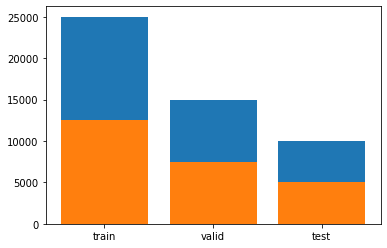

In [ ]:
plt.bar(["train","valid","test"],[x_train.shape[0],x_val.shape[0],x_test.shape[0]])
plt.bar(["train","valid","test"],[y_train.sum(),y_val.sum(),y_test.sum()])

# FUNCTIONs are here 

In [ ]:

class TextCNN(Model):

    def __init__(self,
                 maxlen,
                 max_features,
                 embedding_dims,
                 kernel_sizes=[3,4,5,6],
                 class_num=1,
                 last_activation='sigmoid'):
        super(TextCNN, self).__init__()
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.kernel_sizes = kernel_sizes
        self.class_num = class_num
        self.last_activation = last_activation
        self.embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)
        self.convs = []
        self.max_poolings = []
        for kernel_size in self.kernel_sizes:
            self.convs.append(Conv1D(128, kernel_size, activation='relu',use_bias=True))
            self.max_poolings.append(GlobalMaxPooling1D())
        self.classifier = Dense(self.class_num, activation=self.last_activation,
                                kernel_regularizer=regularizers.l1(0.01))

    def call(self, inputs):
        if len(inputs.get_shape()) != 2:
            raise ValueError('The rank of inputs of TextCNN must be 2, but now is %d' % len(inputs.get_shape()))
        if inputs.get_shape()[1] != self.maxlen:
            raise ValueError('The maxlen of inputs of TextCNN must be %d, but now is %d' % (self.maxlen, inputs.get_shape()[1]))
        # Embedding part can try multichannel as same as origin paper
        embedding = self.embedding(inputs)
        convs = []
        for i in range(len(self.kernel_sizes)):
            c = self.convs[i](embedding)
            c = self.max_poolings[i](c)
            convs.append(c)
        x = Concatenate()(convs)
        output = self.classifier(x)
        return output


def optimizer(name_of_optim,lr):

    if name_of_optim=="sgd":
        optim=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0, nesterov=False, name='SGD')
    if name_of_optim=="sgd_mntm":
        optim=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True, name='SGD')
    if name_of_optim=="adagrad":
        optim=tf.keras.optimizers.Adagrad(learning_rate=lr, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')
    if name_of_optim=="rmsprop":
        optim=tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,name='RMSprop')
    if name_of_optim=="adadelta":
        optim= tf.keras.optimizers.Adadelta(learning_rate=lr, rho=0.95, epsilon=1e-07, name='Adadelta')
    if name_of_optim=="adam":
        optim=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
    return optim




def training(name_of_optim,lr,epoch,BS):

    print('\nTrain...')
    model = TextCNN(maxlen, max_features, embedding_dims)

    optim=optimizer(name_of_optim,lr)
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

    history=model.fit(x_train, y_train,
              batch_size=BS,
              epochs=epoch,
              validation_data=(x_val, y_val),verbose=0)

    print("\n*********\n")
    print("training loss=")
    print(list(np. around(np. array(history.history["loss"]), 2)))
    print("validation loss=")
    print(list(np. around(np. array(history.history["val_loss"]), 2)))
    print("training accuracy=")
    print(list(np. around(np. array(history.history["accuracy"]), 2)))
    print("validation accuracy=")
    print(list(np. around(np. array(history.history["val_accuracy"]), 2)))
    print("\n*********\n")
    
    print("_"*100)
    print('\nTest...')
    results = model.evaluate(x_test, y_test)
    print("_"*100)
    print("Test Loss and Accuracy")
    print("results ", results)

    path="/content/drive/MyDrive/BDA2020_MN/Projects/OptAL/"
    np.save(path+'history_4_{}/history_{}_{}.npy'.format(BS,lr,name_of_optim),history.history)
    tf.keras.models.save_model(model,path+"saved_weight_4_{}/{}_{}/".format(BS,lr,name_of_optim))

    # TRAIN and VALIDATION LOSS curves
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, (len(history_dict['loss']) + 1))
    plt.plot(epochs, loss_values, 'r-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'g-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    # TRAIN and VALIDATION ACCURACY curves

    plt.subplot(122)
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    epochs = range(1, (len(history_dict['accuracy']) + 1))
    plt.plot(epochs, acc_values, 'r-', label='Training acc')
    plt.plot(epochs, val_acc_values, 'g-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    return plt.show()


# All possible combinations are here. for model having 4 cnn layer 

Training is being done for bathch size= 8, for  30 epochs
@@@ Training for sgd for lr= 0.1

Train...

*********

training loss=
[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
validation loss=
[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.52, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 3s 8ms/step - loss: 0.6960 - accuracy: 0.497

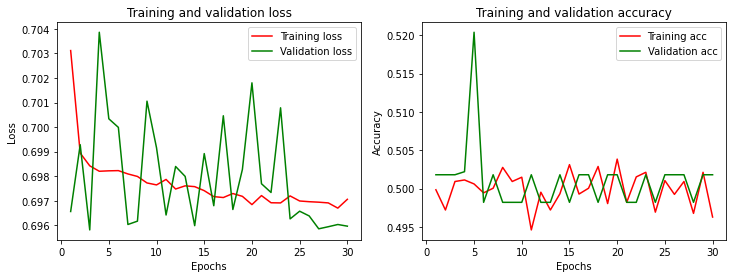

@@@ Training for sgd for lr= 0.01

Train...

*********

training loss=
[0.73, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.49]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 3s 8ms/step - loss: 0.6935 - accuracy: 

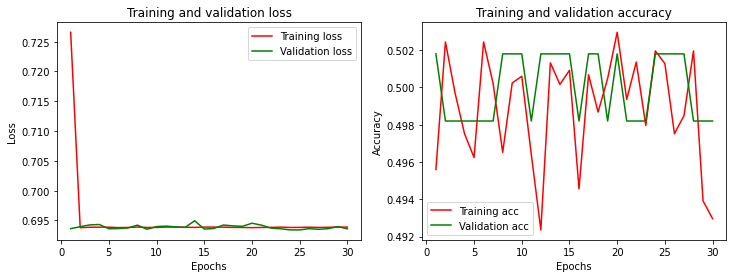

@@@ Training for sgd for lr= 0.001

Train...

*********

training loss=
[0.9, 0.78, 0.72, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.83, 0.74, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
training accuracy=
[0.51, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5]
validation accuracy=
[0.52, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 3s 8ms/step - loss: 0.6932 - accuracy: 

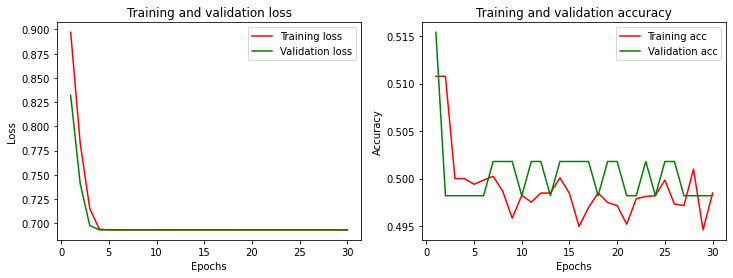

****************************************************************************************************
****************************************************************************************************
@@@ Training for sgd_mntm for lr= 0.1

Train...

*********

training loss=
[0.71, 0.65, 0.6, 0.59, 0.57, 0.56, 0.55, 0.54, 0.54, 0.54, 0.54, 0.53, 0.52, 0.53, 0.53, 0.53, 0.53, 0.52, 0.52, 0.51, 0.51, 0.53, 0.53, 0.53, 0.53, 0.52, 0.53, 0.53, 0.54, 0.55]
validation loss=
[0.72, 0.61, 0.7, 0.61, 0.59, 0.68, 0.53, 0.55, 0.54, 0.71, 0.6, 0.71, 0.61, 0.6, 0.59, 0.6, 0.59, 0.65, 0.56, 0.74, 0.8, 0.6, 0.67, 0.73, 0.6, 0.79, 0.79, 0.77, 0.72, 0.69]
training accuracy=
[0.51, 0.64, 0.71, 0.73, 0.74, 0.75, 0.76, 0.77, 0.77, 0.78, 0.78, 0.78, 0.79, 0.79, 0.79, 0.79, 0.79, 0.8, 0.8, 0.81, 0.81, 0.8, 0.81, 0.8, 0.81, 0.81, 0.81, 0.81, 0.81, 0.8]
validation accuracy=
[0.5, 0.71, 0.5, 0.72, 0.71, 0.74, 0.76, 0.78, 0.76, 0.75, 0.76, 0.75, 0.74, 0.75, 0.74, 0.75, 0.73, 0.76, 0.78, 0.7, 0.75, 0.74, 0.75, 

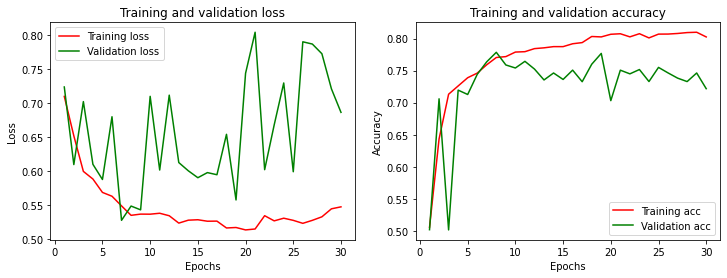

@@@ Training for sgd_mntm for lr= 0.01

Train...

*********

training loss=
[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
validation loss=
[0.69, 0.7, 0.7, 0.69, 0.7, 0.7, 0.7, 0.69, 0.69, 0.7, 0.7, 0.7, 0.69, 0.7, 0.69, 0.7, 0.69, 0.69, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.7, 0.7, 0.7, 0.7, 0.69, 0.7]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.48, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 3s 8ms/step - loss: 0.6950 - accuracy: 0.5027
____________________________________

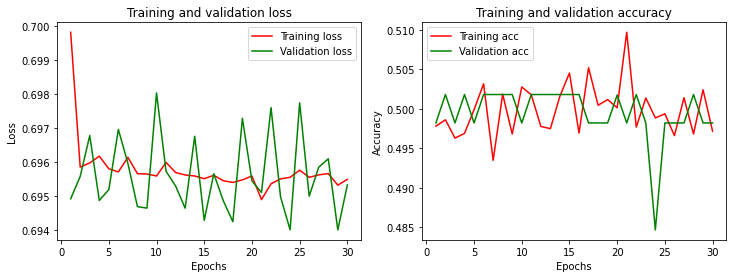

@@@ Training for sgd_mntm for lr= 0.001

Train...

*********

training loss=
[0.73, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
training accuracy=
[0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.49]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 3s 8ms/step - loss: 0.6933 - acc

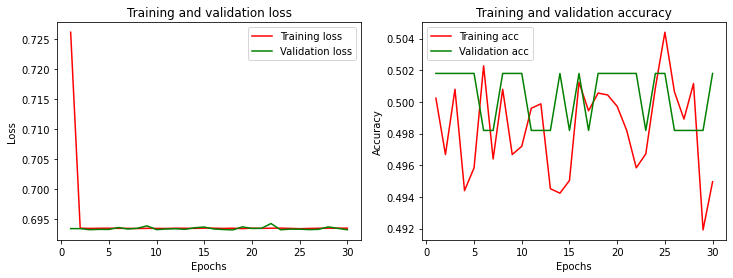

****************************************************************************************************
****************************************************************************************************
@@@ Training for adagrad for lr= 0.1

Train...

*********

training loss=
[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.7, 0.7, 0.69, 0.69, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.49, 0.5]
validation accuracy=
[0.53, 0.5, 0.5, 0.5, 0.5, 0.5, 0.46, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.52, 0.5, 0.5, 0.5, 0.5, 0.5, 0.55, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

_

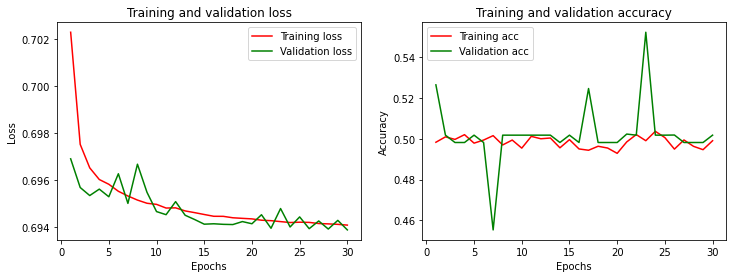

@@@ Training for adagrad for lr= 0.01

Train...

*********

training loss=
[0.71, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 3s 8ms/step - loss: 0.6932 - accuracy

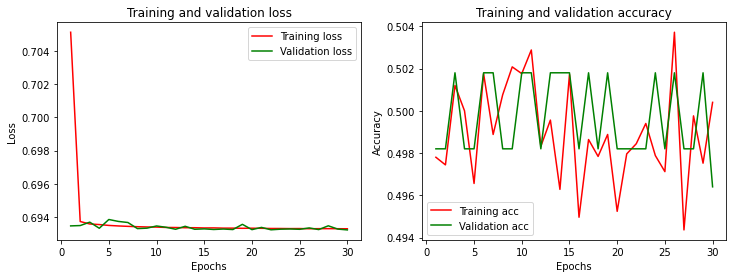

@@@ Training for adagrad for lr= 0.001

Train...

*********

training loss=
[0.85, 0.74, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.77, 0.71, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
training accuracy=
[0.51, 0.52, 0.52, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
validation accuracy=
[0.53, 0.53, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 3s 8ms/step - loss: 0.6932 - accur

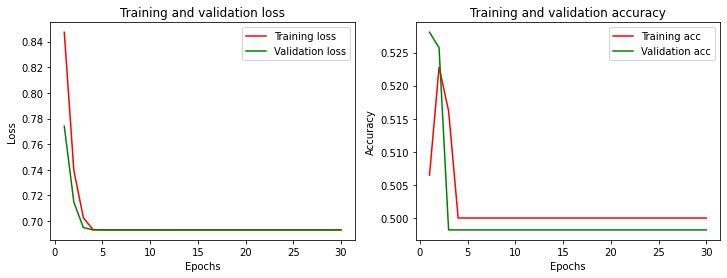

****************************************************************************************************
****************************************************************************************************
@@@ Training for rmsprop for lr= 0.1

Train...

*********

training loss=
[6.0, 2.8, 2.01, 1.73, 1.69, 1.73, 1.45, 1.27, 1.16, 1.13, 1.1, 1.09, 1.07, 1.08, 1.01, 1.02, 1.0, 1.01, 0.98, 0.97, 0.97, 0.96, 0.97, 0.96, 0.97, 0.96, 0.96, 0.96, 0.96, 0.95]
validation loss=
[2.33, 1.52, 2.17, 1.95, 2.29, 1.54, 1.09, 1.03, 1.45, 1.08, 0.98, 0.97, 0.98, 0.96, 0.99, 1.11, 0.99, 0.95, 0.95, 0.98, 0.95, 0.95, 0.96, 0.95, 0.95, 0.97, 0.95, 0.95, 0.96, 0.95]
training accuracy=
[0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
validation accuracy=
[0.51, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



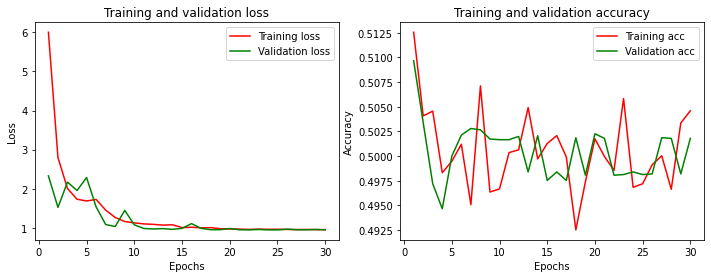

@@@ Training for rmsprop for lr= 0.01

Train...

*********

training loss=
[0.56, 0.54, 0.53, 0.51, 0.47, 0.44, 0.41, 0.36, 0.31, 0.28, 0.25, 0.22, 0.18, 0.15, 0.13, 0.12, 0.1, 0.09, 0.08, 0.08, 0.08, 0.07, 0.08, 0.07, 0.08, 0.07, 0.07, 0.07, 0.08, 0.08]
validation loss=
[0.5, 0.54, 0.63, 0.55, 0.59, 0.84, 0.73, 0.81, 1.52, 1.03, 1.4, 1.29, 1.28, 1.74, 2.12, 2.02, 1.72, 1.97, 1.74, 2.05, 1.88, 1.64, 1.85, 1.94, 3.17, 2.09, 2.3, 2.17, 1.6, 2.06]
training accuracy=
[0.79, 0.84, 0.85, 0.87, 0.89, 0.9, 0.91, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]
validation accuracy=
[0.84, 0.82, 0.83, 0.84, 0.84, 0.84, 0.83, 0.83, 0.79, 0.84, 0.83, 0.83, 0.83, 0.83, 0.82, 0.83, 0.83, 0.83, 0.83, 0.82, 0.83, 0.83, 0.83, 0.83, 0.78, 0.83, 0.83, 0.83, 0.83, 0.84]

*********

____________________________________________________________________________________________________

Test...
313/313 [===================

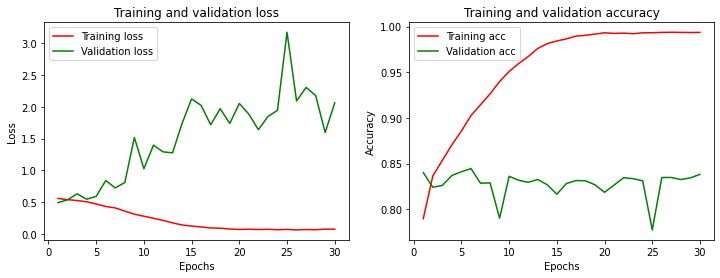

@@@ Training for rmsprop for lr= 0.001

Train...

*********

training loss=
[0.51, 0.36, 0.32, 0.3, 0.28, 0.27, 0.26, 0.24, 0.23, 0.22, 0.2, 0.19, 0.18, 0.17, 0.16, 0.14, 0.13, 0.12, 0.11, 0.11, 0.1, 0.09, 0.08, 0.08, 0.07, 0.07, 0.06, 0.06, 0.05, 0.05]
validation loss=
[0.43, 0.35, 0.33, 0.32, 0.33, 0.32, 0.32, 0.32, 0.36, 0.33, 0.33, 0.38, 0.35, 0.39, 0.42, 0.39, 0.45, 0.41, 0.48, 0.44, 0.55, 0.54, 0.48, 0.5, 0.5, 0.52, 0.55, 0.51, 0.51, 0.58]
training accuracy=
[0.77, 0.86, 0.87, 0.88, 0.89, 0.9, 0.9, 0.91, 0.92, 0.92, 0.93, 0.94, 0.94, 0.95, 0.95, 0.96, 0.96, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]
validation accuracy=
[0.83, 0.86, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.86, 0.88, 0.87, 0.86, 0.87, 0.86, 0.86, 0.87, 0.86, 0.87, 0.85, 0.87, 0.85, 0.85, 0.86, 0.86, 0.87, 0.86, 0.86, 0.86, 0.86, 0.84]

*********

____________________________________________________________________________________________________

Test...
313/313 [===================

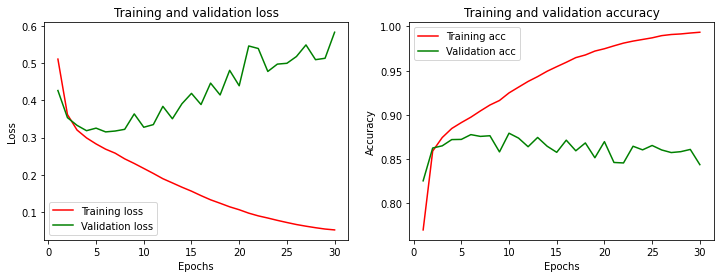

****************************************************************************************************
****************************************************************************************************
@@@ Training for adadelta for lr= 0.1

Train...

*********

training loss=
[0.73, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

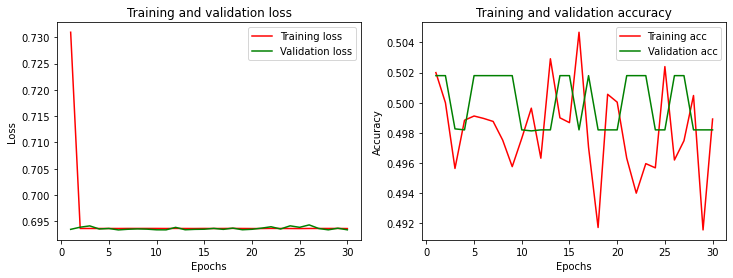

@@@ Training for adadelta for lr= 0.01

Train...

*********

training loss=
[0.91, 0.81, 0.74, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.85, 0.77, 0.72, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
training accuracy=
[0.52, 0.59, 0.56, 0.52, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.49, 0.5, 0.49, 0.5, 0.5, 0.5]
validation accuracy=
[0.57, 0.6, 0.5, 0.57, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 3s 8ms/step - loss: 0.6932 - a

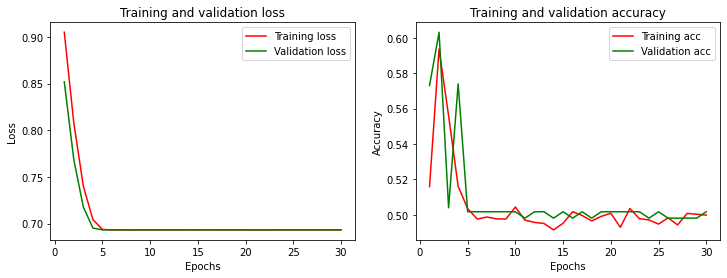

@@@ Training for adadelta for lr= 0.001

Train...

*********

training loss=
[0.96, 0.95, 0.94, 0.93, 0.91, 0.9, 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.82, 0.81, 0.8, 0.79, 0.79, 0.78, 0.77, 0.77, 0.76, 0.75, 0.75, 0.74, 0.74, 0.73, 0.73, 0.72]
validation loss=
[0.96, 0.94, 0.93, 0.92, 0.91, 0.9, 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8, 0.8, 0.79, 0.78, 0.78, 0.77, 0.76, 0.76, 0.75, 0.75, 0.74, 0.74, 0.73, 0.73, 0.72]
training accuracy=
[0.51, 0.52, 0.53, 0.55, 0.56, 0.56, 0.57, 0.58, 0.58, 0.59, 0.59, 0.59, 0.59, 0.59, 0.58, 0.56, 0.55, 0.54, 0.53, 0.53, 0.53, 0.53, 0.53, 0.54, 0.53, 0.54, 0.53, 0.53, 0.55, 0.56]
validation accuracy=
[0.51, 0.52, 0.53, 0.54, 0.54, 0.55, 0.56, 0.56, 0.56, 0.57, 0.57, 0.57, 0.57, 0.56, 0.55, 0.54, 0.54, 0.53, 0.52, 0.53, 0.52, 0.52, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.55, 0.56]

*********

____________________________________________________________________________________________________

Test...
313/313 [================

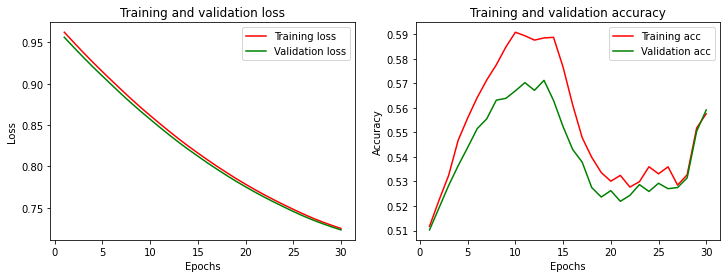

****************************************************************************************************
****************************************************************************************************
@@@ Training for adam for lr= 0.1

Train...

*********

training loss=
[14.93, 3.26, 2.25, 8.11, 3.39, 2.45, 2.18, 1.73, 3.04, 0.94, 0.89, 0.78, 0.77, 0.78, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76]
validation loss=
[1.63, 2.38, 0.92, 8.89, 2.48, 2.22, 1.89, 1.66, 0.97, 1.09, 0.83, 0.8, 0.85, 0.75, 0.76, 0.77, 0.8, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.77, 0.75, 0.76, 0.76, 0.76, 0.76]
training accuracy=
[0.52, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

**

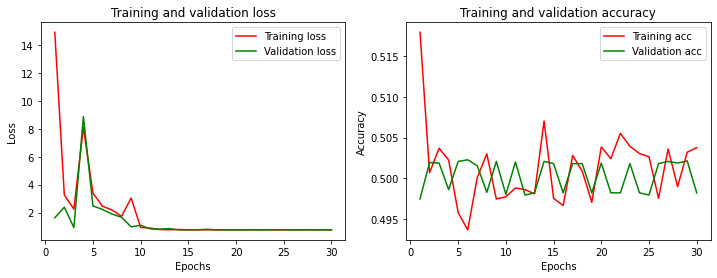

@@@ Training for adam for lr= 0.01

Train...

*********

training loss=
[0.62, 0.5, 0.39, 0.35, 0.33, 0.33, 0.26, 0.28, 0.3, 0.28, 0.23, 0.23, 0.29, 0.27, 0.34, 0.25, 0.25, 0.25, 0.29, 0.26, 0.23, 0.33, 0.36, 0.26, 0.25, 0.23, 0.32, 0.27, 0.24, 0.35]
validation loss=
[0.58, 0.57, 0.54, 0.55, 0.52, 0.65, 0.79, 0.88, 1.18, 1.46, 1.41, 1.54, 1.81, 1.95, 3.14, 2.29, 2.82, 2.83, 2.57, 4.26, 3.45, 4.63, 4.38, 4.28, 5.62, 9.2, 5.48, 5.68, 6.48, 7.78]
training accuracy=
[0.77, 0.84, 0.87, 0.89, 0.92, 0.93, 0.94, 0.95, 0.95, 0.96, 0.96, 0.96, 0.96, 0.97, 0.97, 0.97, 0.98, 0.97, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.99, 0.98]
validation accuracy=
[0.78, 0.83, 0.83, 0.84, 0.84, 0.81, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.81, 0.83, 0.83, 0.83, 0.82, 0.82, 0.83, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.8, 0.82, 0.81, 0.83, 0.82]

*********

____________________________________________________________________________________________________

Test...
313/313 [====================

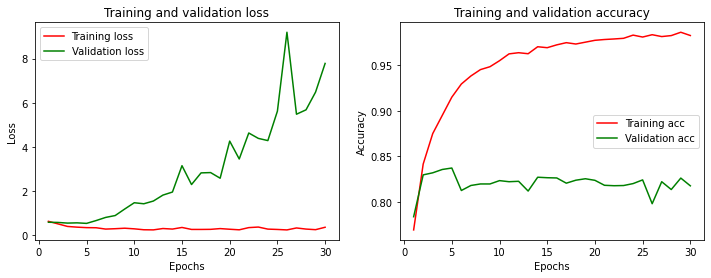

@@@ Training for adam for lr= 0.001

Train...

*********

training loss=
[0.49, 0.33, 0.26, 0.21, 0.17, 0.13, 0.1, 0.08, 0.07, 0.05, 0.05, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
validation loss=
[0.38, 0.35, 0.35, 0.36, 0.4, 0.45, 0.49, 0.54, 0.57, 0.58, 0.62, 0.66, 0.63, 0.64, 0.64, 0.64, 0.63, 0.65, 0.65, 0.65, 0.65, 0.65, 0.66, 0.65, 0.65, 0.67, 0.68, 0.68, 0.68, 0.69]
training accuracy=
[0.78, 0.88, 0.91, 0.93, 0.95, 0.97, 0.98, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.85, 0.86, 0.86, 0.86, 0.86, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.84, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.84, 0.85, 0.85, 0.85]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 3s 8

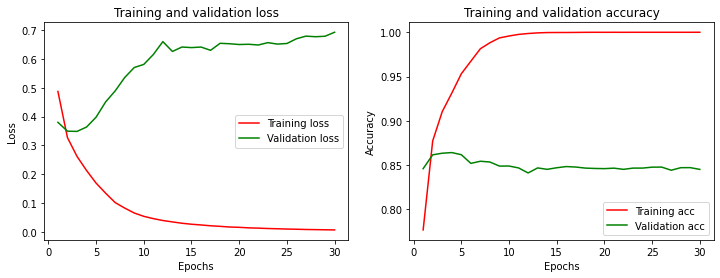

****************************************************************************************************
****************************************************************************************************


In [ ]:
# model having 4 different cnn layer with gfrid 3,4 and 5 and 6 
batch_size = 8
epoch = 30
print("Training is being done for bathch size= {}, for  {} epochs".format(batch_size,epoch) )

l=["sgd","sgd_mntm","adagrad","rmsprop","adadelta","adam"]
for name_of_optim in l:
    for lr in [0.1,0.01,0.001]:
        print("@@@ Training for {} for lr= {}".format(name_of_optim,lr))
        training(name_of_optim,lr,epoch,batch_size)
    print("*"*100)
    print("*"*100)

Training is being done for bathch size= 32, for  30 epochs
@@@ Training for sgd for lr= 0.1

Train...

*********

training loss=
[0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
validation loss=
[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 8ms/step - loss: 0.6970 - accuracy: 

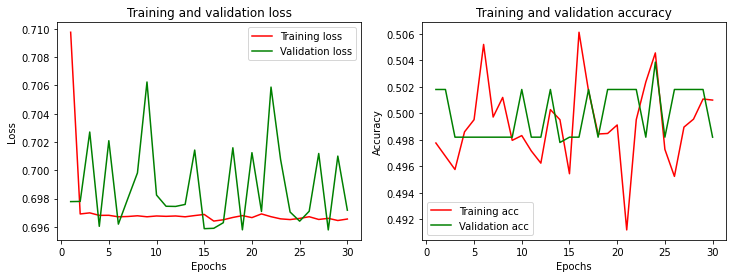

@@@ Training for sgd for lr= 0.01

Train...

*********

training loss=
[0.82, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.72, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 8ms/step - loss: 0.6936 - accuracy: 0.

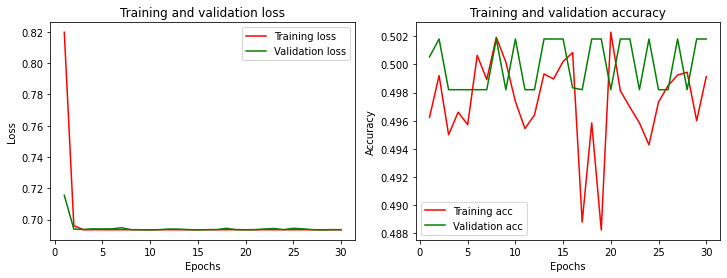

@@@ Training for sgd for lr= 0.001

Train...

*********

training loss=
[0.94, 0.9, 0.87, 0.84, 0.81, 0.79, 0.76, 0.75, 0.73, 0.72, 0.71, 0.7, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.92, 0.89, 0.85, 0.82, 0.8, 0.77, 0.75, 0.74, 0.72, 0.71, 0.7, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
training accuracy=
[0.5, 0.51, 0.5, 0.51, 0.51, 0.52, 0.52, 0.52, 0.51, 0.51, 0.51, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49]
validation accuracy=
[0.5, 0.5, 0.51, 0.51, 0.52, 0.51, 0.51, 0.51, 0.51, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 8ms/step - loss: 0.6932 - 

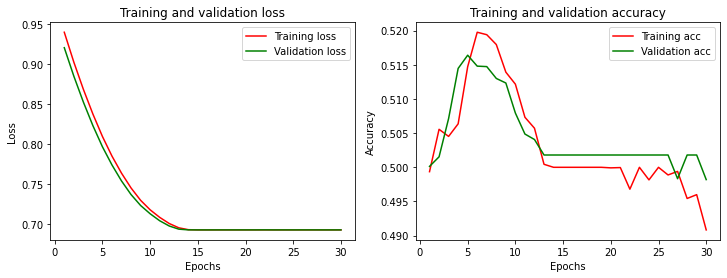

****************************************************************************************************
****************************************************************************************************
@@@ Training for sgd_mntm for lr= 0.1

Train...

*********

training loss=
[0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.58, 0.54, 0.51, 0.49, 0.48, 0.46, 0.46, 0.44]
validation loss=
[0.7, 0.7, 0.7, 0.71, 0.7, 0.7, 0.7, 0.71, 0.71, 0.7, 0.71, 0.7, 0.7, 0.7, 0.72, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.61, 0.57, 0.53, 0.53, 0.52, 0.52, 0.51, 0.53, 0.5]
training accuracy=
[0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.55, 0.72, 0.75, 0.77, 0.78, 0.79, 0.8, 0.81, 0.81]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.7, 0.73, 0.76, 0.77, 0.78, 0.76, 0.78, 0.78, 0.78]

*********

________

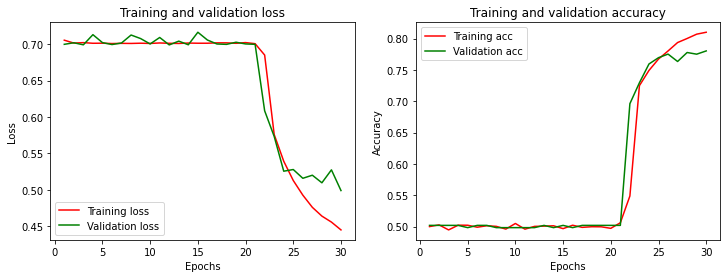

@@@ Training for sgd_mntm for lr= 0.01

Train...

*********

training loss=
[0.71, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.69, 0.69, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.7, 0.69, 0.69, 0.69, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.7]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 8ms/step - loss: 0.6958 - accuracy: 0

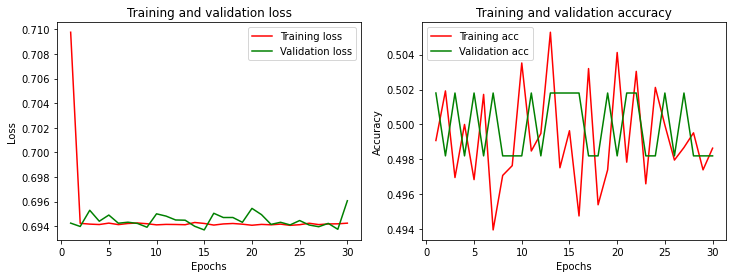

@@@ Training for sgd_mntm for lr= 0.001

Train...

*********

training loss=
[0.82, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.71, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 8ms/step - loss: 0.6932 - accurac

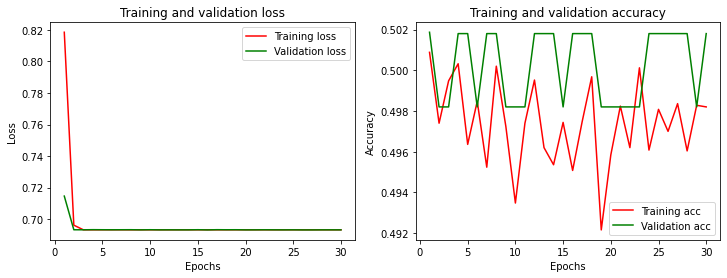

****************************************************************************************************
****************************************************************************************************
@@@ Training for adagrad for lr= 0.1

Train...


In [ ]:
# model having 4 different cnn layer with gfrid 3,4 and 5 and 6 
batch_size = 32
epoch = 30
print("Training is being done for bathch size= {}, for  {} epochs".format(batch_size,epoch) )

l=["sgd","sgd_mntm","adagrad","rmsprop","adadelta","adam"]
for name_of_optim in l:
    for lr in [0.1,0.01,0.001]:
        print("@@@ Training for {} for lr= {}".format(name_of_optim,lr))
        training(name_of_optim,lr,epoch,batch_size)
    print("*"*100)
    print("*"*100)

In [ ]:
# # model having 4 different cnn layer with gfrid 3,4 and 5 and 6 
batch_size = 128
epoch = 30
print("Training is being done for bathch size= {}, for  {} epochs".format(batch_size,epoch) )

l=["sgd","sgd_mntm","adagrad","rmsprop","adadelta","adam"]
for name_of_optim in l:
    for lr in [0.1,0.01,0.001]:
        print("@@@ Training for {} for lr= {}".format(name_of_optim,lr))
        training(name_of_optim,lr,epoch,batch_size)
    print("*"*100)
    print("*"*100)

Training is being done for bathch size= 128, for  30 epochs
@@@ Training for sgd for lr= 0.1

Train...

*********

training loss=
[0.75, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
validation loss=
[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 6ms/step - loss: 0.6959 - accuracy: 0

FileNotFoundError: ignored

In [ ]:
# model having 4 different cnn layer with gfrid 3,4 and 5 and 6 
batch_size = 512
epoch = 30
print("Training is being doe for bathch size= {}, for  {} epochs".format(batch_size,epoch) )


l=["sgd","sgd_mntm","adagrad","rmsprop","adadelta","adam"]
for name_of_optim in l:
    for lr in [0.1,0.01,0.001]:
        print("@@@ Training for {} for lr= {}".format(name_of_optim,lr))
        training(name_of_optim,lr,epoch,batch_size)
    print("*"*100)
    print("*"*100)        
     

# new section:::: MOdel having 2 layer  

In [ ]:

class TextCNN(Model):

    def __init__(self,
                 maxlen,
                 max_features,
                 embedding_dims,
                 kernel_sizes=[3,4],
                 class_num=1,
                 last_activation='sigmoid'):
        super(TextCNN, self).__init__()
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.kernel_sizes = kernel_sizes
        self.class_num = class_num
        self.last_activation = last_activation
        self.embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)
        self.convs = []
        self.max_poolings = []
        for kernel_size in self.kernel_sizes:
            self.convs.append(Conv1D(128, kernel_size, activation='relu',use_bias=True))
            self.max_poolings.append(GlobalMaxPooling1D())
        self.classifier = Dense(self.class_num, activation=self.last_activation,
                                kernel_regularizer=regularizers.l1(0.001))

    def call(self, inputs):
        if len(inputs.get_shape()) != 2:
            raise ValueError('The rank of inputs of TextCNN must be 2, but now is %d' % len(inputs.get_shape()))
        if inputs.get_shape()[1] != self.maxlen:
            raise ValueError('The maxlen of inputs of TextCNN must be %d, but now is %d' % (self.maxlen, inputs.get_shape()[1]))
        # Embedding part can try multichannel as same as origin paper
        embedding = self.embedding(inputs)
        convs = []
        for i in range(len(self.kernel_sizes)):
            c = self.convs[i](embedding)
            c = self.max_poolings[i](c)
            convs.append(c)
        x = Concatenate()(convs)
        output = self.classifier(x)
        return output

    


def optimizer(name_of_optim,lr):

    if name_of_optim=="sgd":
        optim=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0, nesterov=False, name='SGD')
    if name_of_optim=="sgd_mntm":
        optim=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True, name='SGD')
    if name_of_optim=="adagrad":
        optim=tf.keras.optimizers.Adagrad(learning_rate=lr, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')
    if name_of_optim=="rmsprop":
        optim=tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,name='RMSprop')
    if name_of_optim=="adadelta":
        optim= tf.keras.optimizers.Adadelta(learning_rate=lr, rho=0.95, epsilon=1e-07, name='Adadelta')
    if name_of_optim=="adam":
        optim=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
    return optim




def training(name_of_optim,lr,epoch,BS):

    print('\nTrain...')
    model = TextCNN(maxlen, max_features, embedding_dims)

    optim=optimizer(name_of_optim,lr)
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

    history=model.fit(x_train, y_train,
              batch_size=BS,
              epochs=epoch,
              validation_data=(x_val, y_val),verbose=0)

    print("\n*********\n")
    print("training loss=")
    print(list(np. around(np. array(history.history["loss"]), 2)))
    print("validation loss=")
    print(list(np. around(np. array(history.history["val_loss"]), 2)))
    print("training accuracy=")
    print(list(np. around(np. array(history.history["accuracy"]), 2)))
    print("validation accuracy=")
    print(list(np. around(np. array(history.history["val_accuracy"]), 2)))
    print("\n*********\n")
    
    print("_"*100)
    print('\nTest...')
    results = model.evaluate(x_test, y_test)
    print("_"*100)
    print("Test Loss and Accuracy")
    print("results ", results)

    path="/content/drive/MyDrive/BDA2020_MN/Projects/OptAL/"
    np.save(path+'history_2_{}/history_{}_{}.npy'.format(BS,lr,name_of_optim),history.history)
    tf.keras.models.save_model(model,path+"./saved_weight_2_{}/{}_{}/".format(BS,lr,name_of_optim))

    # TRAIN and VALIDATION LOSS curves
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, (len(history_dict['loss']) + 1))
    plt.plot(epochs, loss_values, 'r-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'g-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    # TRAIN and VALIDATION ACCURACY curves

    plt.subplot(122)
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    epochs = range(1, (len(history_dict['accuracy']) + 1))
    plt.plot(epochs, acc_values, 'r-', label='Training acc')
    plt.plot(epochs, val_acc_values, 'g-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    return plt.show()


Training is being done for bathch size= 8, for  30 epochs
@@@ Training for sgd for lr= 0.1

Train...

*********

training loss=
[0.64, 0.47, 0.39, 0.34, 0.31, 0.28, 0.26, 0.23, 0.21, 0.19, 0.16, 0.14, 0.12, 0.1, 0.08, 0.07, 0.05, 0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
validation loss=
[0.53, 0.43, 0.42, 0.36, 0.37, 0.34, 0.35, 0.36, 0.38, 0.39, 0.4, 0.45, 0.48, 0.53, 0.56, 0.59, 0.62, 0.66, 0.65, 0.64, 0.63, 0.63, 0.63, 0.62, 0.62, 0.63, 0.63, 0.63, 0.63, 0.63]
training accuracy=
[0.61, 0.78, 0.83, 0.86, 0.87, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.98, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.74, 0.81, 0.82, 0.84, 0.84, 0.86, 0.86, 0.86, 0.85, 0.85, 0.85, 0.85, 0.86, 0.85, 0.85, 0.85, 0.86, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85]

*********

_______________________________________________________________________________________________

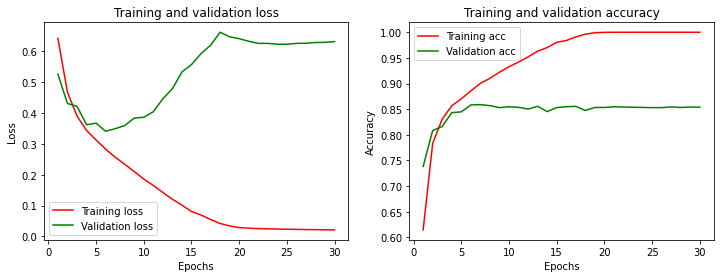

@@@ Training for sgd for lr= 0.01

Train...

*********

training loss=
[0.71, 0.7, 0.68, 0.65, 0.63, 0.6, 0.58, 0.55, 0.52, 0.5, 0.49, 0.47, 0.46, 0.44, 0.42, 0.41, 0.39, 0.38, 0.37, 0.35, 0.34, 0.33, 0.32, 0.31, 0.3, 0.29, 0.28, 0.28, 0.27, 0.26]
validation loss=
[0.7, 0.7, 0.66, 0.64, 0.61, 0.6, 0.57, 0.54, 0.52, 0.5, 0.49, 0.48, 0.46, 0.45, 0.44, 0.43, 0.41, 0.4, 0.4, 0.39, 0.38, 0.38, 0.38, 0.37, 0.36, 0.36, 0.35, 0.35, 0.35, 0.36]
training accuracy=
[0.52, 0.58, 0.64, 0.64, 0.66, 0.68, 0.7, 0.73, 0.75, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.84, 0.85, 0.86, 0.86, 0.87, 0.88, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.91]
validation accuracy=
[0.52, 0.54, 0.63, 0.63, 0.67, 0.68, 0.71, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.82, 0.83, 0.83, 0.84, 0.84, 0.85, 0.84, 0.85, 0.85, 0.85, 0.86, 0.86, 0.86, 0.86]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] -

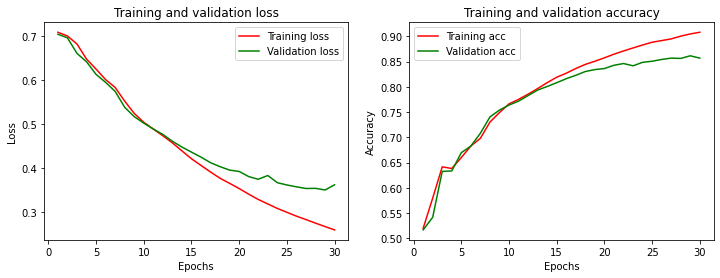

@@@ Training for sgd for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.68, 0.68, 0.68, 0.67, 0.67]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.68, 0.68, 0.67, 0.67, 0.66]
training accuracy=
[0.51, 0.54, 0.55, 0.56, 0.58, 0.6, 0.6, 0.62, 0.62, 0.63, 0.65, 0.65, 0.66, 0.66, 0.65, 0.67, 0.67, 0.68, 0.68, 0.69, 0.68, 0.69, 0.69, 0.68, 0.68, 0.68, 0.67, 0.66, 0.63, 0.63]
validation accuracy=
[0.52, 0.53, 0.56, 0.53, 0.59, 0.6, 0.54, 0.6, 0.62, 0.63, 0.64, 0.64, 0.64, 0.64, 0.66, 0.66, 0.67, 0.66, 0.68, 0.67, 0.67, 0.68, 0.68, 0.66, 0.67, 0.67, 0.66, 0.63, 0.64, 0.63]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 5ms/ste

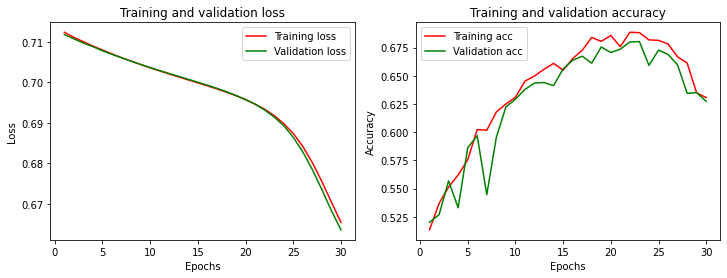

****************************************************************************************************
****************************************************************************************************
@@@ Training for sgd_mntm for lr= 0.1

Train...

*********

training loss=
[0.65, 0.53, 0.49, 0.48, 0.47, 0.47, 0.46, 0.48, 0.48, 0.48, 0.5, 0.5, 0.51, 0.5, 0.53, 0.53, 0.53, 0.54, 0.54, 0.55, 0.57, 0.53, 0.56, 0.63, 0.62, 0.63, 0.58, 0.61, 0.61, 0.59]
validation loss=
[0.58, 0.46, 0.45, 0.5, 0.51, 0.51, 0.46, 0.47, 0.51, 0.69, 0.66, 0.56, 0.58, 0.56, 0.71, 0.66, 0.66, 0.91, 0.73, 0.8, 0.81, 0.77, 0.69, 0.83, 0.91, 0.82, 0.8, 0.92, 0.82, 0.92]
training accuracy=
[0.6, 0.75, 0.78, 0.79, 0.8, 0.8, 0.8, 0.8, 0.79, 0.8, 0.78, 0.79, 0.78, 0.78, 0.77, 0.77, 0.76, 0.76, 0.76, 0.75, 0.73, 0.76, 0.74, 0.72, 0.69, 0.69, 0.71, 0.69, 0.68, 0.68]
validation accuracy=
[0.7, 0.79, 0.81, 0.77, 0.8, 0.79, 0.79, 0.8, 0.8, 0.77, 0.78, 0.76, 0.78, 0.77, 0.63, 0.74, 0.74, 0.68, 0.6, 0.62, 0.71, 0.69, 0.72, 0

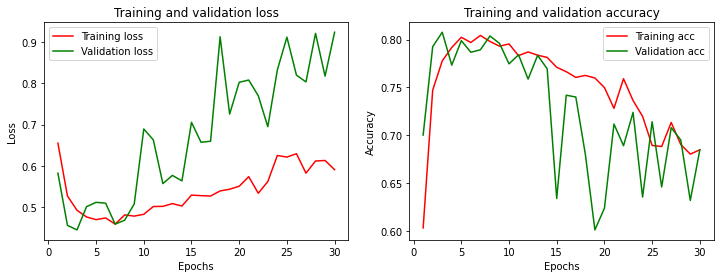

@@@ Training for sgd_mntm for lr= 0.01

Train...

*********

training loss=
[0.64, 0.49, 0.39, 0.34, 0.31, 0.28, 0.25, 0.23, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.07, 0.05, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
validation loss=
[0.56, 0.43, 0.4, 0.38, 0.34, 0.34, 0.35, 0.35, 0.37, 0.37, 0.4, 0.43, 0.47, 0.53, 0.52, 0.57, 0.6, 0.62, 0.63, 0.64, 0.62, 0.62, 0.62, 0.62, 0.63, 0.62, 0.63, 0.63, 0.63, 0.64]
training accuracy=
[0.62, 0.77, 0.83, 0.86, 0.88, 0.89, 0.9, 0.92, 0.92, 0.94, 0.95, 0.96, 0.97, 0.97, 0.98, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.72, 0.8, 0.83, 0.84, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.85, 0.85, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] 

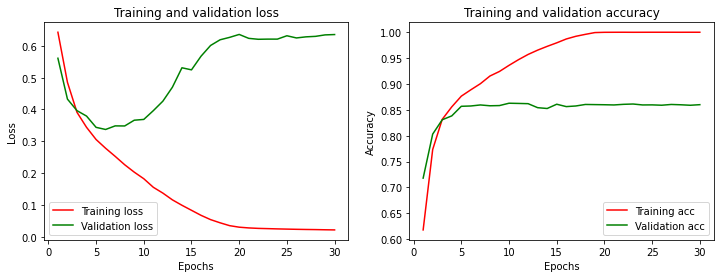

@@@ Training for sgd_mntm for lr= 0.001

Train...

*********

training loss=
[0.71, 0.7, 0.69, 0.68, 0.65, 0.6, 0.57, 0.54, 0.52, 0.5, 0.48, 0.47, 0.45, 0.44, 0.42, 0.41, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.32, 0.31, 0.3, 0.29, 0.28, 0.27, 0.26]
validation loss=
[0.7, 0.7, 0.69, 0.66, 0.62, 0.58, 0.55, 0.53, 0.51, 0.49, 0.48, 0.47, 0.45, 0.44, 0.44, 0.42, 0.41, 0.41, 0.4, 0.4, 0.39, 0.38, 0.38, 0.37, 0.37, 0.36, 0.36, 0.36, 0.36, 0.35]
training accuracy=
[0.52, 0.58, 0.61, 0.61, 0.64, 0.7, 0.72, 0.74, 0.75, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.82, 0.83, 0.84, 0.85, 0.85, 0.86, 0.87, 0.87, 0.88, 0.88, 0.89, 0.89, 0.9, 0.9, 0.91]
validation accuracy=
[0.62, 0.59, 0.55, 0.59, 0.7, 0.7, 0.72, 0.75, 0.76, 0.77, 0.78, 0.79, 0.79, 0.8, 0.81, 0.81, 0.82, 0.82, 0.83, 0.83, 0.84, 0.84, 0.84, 0.85, 0.85, 0.85, 0.85, 0.86, 0.86, 0.86]

*********

____________________________________________________________________________________________________

Test...
313/313 [==========================

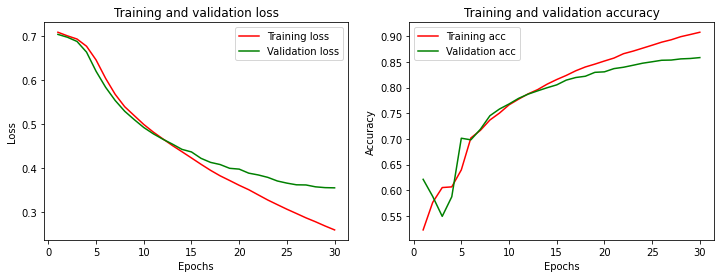

****************************************************************************************************
****************************************************************************************************
@@@ Training for adagrad for lr= 0.1

Train...

*********

training loss=
[0.54, 0.39, 0.32, 0.27, 0.23, 0.19, 0.15, 0.12, 0.09, 0.07, 0.05, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
validation loss=
[0.44, 0.38, 0.34, 0.33, 0.33, 0.34, 0.36, 0.4, 0.41, 0.45, 0.47, 0.5, 0.52, 0.54, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.62, 0.63, 0.64, 0.64, 0.65, 0.65, 0.66, 0.66, 0.66]
training accuracy=
[0.72, 0.83, 0.87, 0.89, 0.91, 0.93, 0.95, 0.97, 0.98, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.8, 0.84, 0.86, 0.86, 0.86, 0.87, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.8

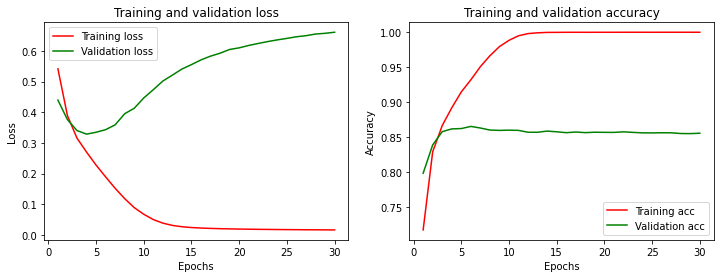

@@@ Training for adagrad for lr= 0.01

Train...

*********

training loss=
[0.7, 0.64, 0.59, 0.55, 0.51, 0.48, 0.45, 0.42, 0.4, 0.39, 0.37, 0.36, 0.34, 0.33, 0.32, 0.31, 0.3, 0.29, 0.29, 0.28, 0.27, 0.27, 0.26, 0.25, 0.25, 0.24, 0.24, 0.23, 0.23, 0.22]
validation loss=
[0.68, 0.61, 0.57, 0.54, 0.5, 0.47, 0.44, 0.42, 0.41, 0.4, 0.39, 0.38, 0.37, 0.36, 0.36, 0.35, 0.35, 0.34, 0.34, 0.34, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.32, 0.32, 0.32]
training accuracy=
[0.57, 0.67, 0.7, 0.73, 0.76, 0.78, 0.8, 0.82, 0.83, 0.84, 0.85, 0.85, 0.86, 0.87, 0.87, 0.88, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.91, 0.91, 0.91, 0.91, 0.92, 0.92, 0.92, 0.92]
validation accuracy=
[0.69, 0.67, 0.71, 0.74, 0.76, 0.78, 0.8, 0.81, 0.82, 0.83, 0.83, 0.84, 0.84, 0.85, 0.85, 0.85, 0.85, 0.86, 0.86, 0.86, 0.86, 0.86, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87]

*********

____________________________________________________________________________________________________

Test...
313/313 [========================

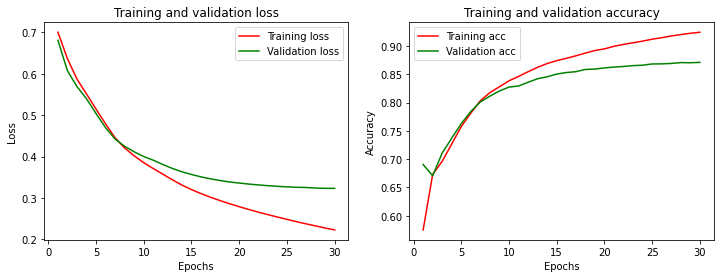

@@@ Training for adagrad for lr= 0.001

Train...


In [ ]:
# model having 2 different cnn layer with gfrid 3,4
batch_size = 8
epoch = 30
print("Training is being done for bathch size= {}, for  {} epochs".format(batch_size,epoch) )

l=["sgd","sgd_mntm","adagrad","rmsprop","adadelta","adam"]
for name_of_optim in l:
    for lr in [0.1,0.01,0.001]:
        print("@@@ Training for {} for lr= {}".format(name_of_optim,lr))
        training(name_of_optim,lr,epoch,batch_size)
    print("*"*100)
    print("*"*100)

Training is being done for bathch size= 8, for  30 epochs
@@@ Training for sgd for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
training accuracy=
[0.52, 0.54, 0.54, 0.57, 0.58, 0.59, 0.59, 0.61, 0.6, 0.62, 0.62, 0.64, 0.64, 0.63, 0.64, 0.64, 0.63, 0.63, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.62, 0.62, 0.63, 0.62]
validation accuracy=
[0.53, 0.51, 0.56, 0.58, 0.59, 0.54, 0.57, 0.55, 0.62, 0.62, 0.61, 0.62, 0.62, 0.62, 0.63, 0.63, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61]

*********

____________________________________________________________________________________________________

Test...
313

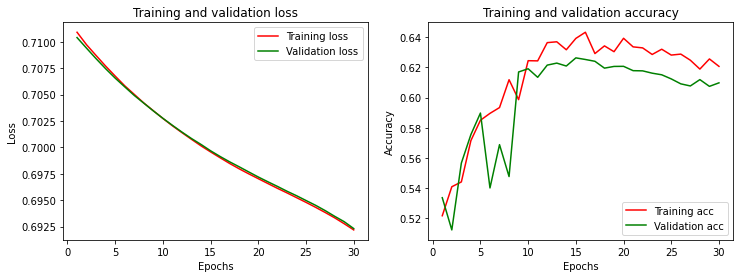

****************************************************************************************************
****************************************************************************************************
@@@ Training for sgd_mntm for lr= 0.001

Train...

*********

training loss=
[0.71, 0.7, 0.7, 0.67, 0.66, 0.64, 0.62, 0.58, 0.56, 0.52, 0.48, 0.46, 0.45, 0.43, 0.41, 0.4, 0.38, 0.36, 0.35, 0.34, 0.32, 0.31, 0.3, 0.29, 0.28, 0.28, 0.27, 0.26, 0.25, 0.24]
validation loss=
[0.71, 0.7, 0.69, 0.66, 0.65, 0.64, 0.6, 0.57, 0.54, 0.5, 0.48, 0.47, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4, 0.39, 0.38, 0.38, 0.38, 0.38, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37]
training accuracy=
[0.52, 0.55, 0.58, 0.62, 0.61, 0.63, 0.67, 0.7, 0.72, 0.75, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.87, 0.88, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.91, 0.91]
validation accuracy=
[0.5, 0.5, 0.6, 0.6, 0.61, 0.64, 0.68, 0.71, 0.73, 0.77, 0.78, 0.79, 0.8, 0.8, 0.81, 0.82, 0.82, 0.83, 0.83, 0.84, 0.84, 0.84, 0.84, 0

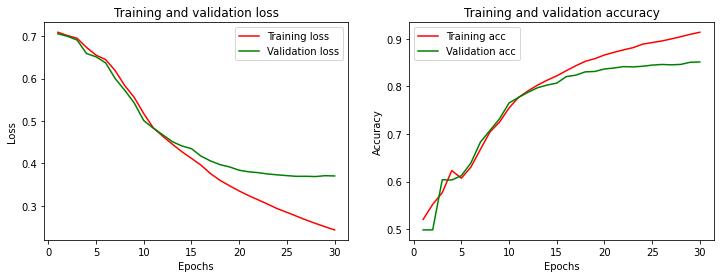

****************************************************************************************************
****************************************************************************************************
@@@ Training for adagrad for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.69, 0.69, 0.68, 0.67, 0.66, 0.65, 0.64, 0.64, 0.63, 0.63, 0.62, 0.62, 0.62, 0.61, 0.61, 0.61, 0.6, 0.6, 0.59, 0.59, 0.59, 0.58]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.69, 0.68, 0.67, 0.66, 0.65, 0.65, 0.64, 0.63, 0.63, 0.62, 0.62, 0.62, 0.61, 0.61, 0.61, 0.6, 0.6, 0.6, 0.59, 0.59, 0.58, 0.58]
training accuracy=
[0.51, 0.58, 0.62, 0.66, 0.69, 0.71, 0.71, 0.71, 0.71, 0.7, 0.71, 0.73, 0.73, 0.73, 0.73, 0.72, 0.71, 0.7, 0.7, 0.7, 0.71, 0.71, 0.72, 0.72, 0.72, 0.73, 0.73, 0.73, 0.73, 0.73]
validation accuracy=
[0.54, 0.59, 0.62, 0.66, 0.68, 0.7, 0.7, 0.7, 0.7, 0.7, 0.71, 0.71, 0.72, 0.72, 0.72, 0.7, 0.69, 0.69, 0.69, 0.7, 0.7, 0.71, 0.71, 0.71, 0

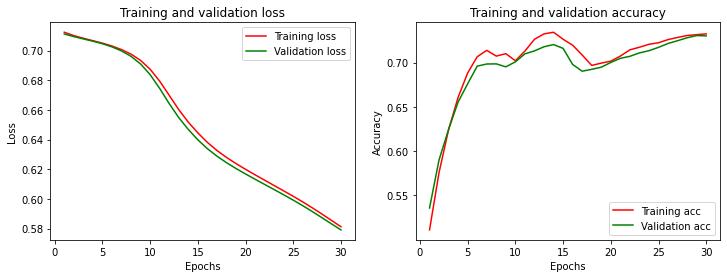

****************************************************************************************************
****************************************************************************************************
@@@ Training for rmsprop for lr= 0.001

Train...

*********

training loss=
[0.41, 0.29, 0.25, 0.22, 0.18, 0.16, 0.13, 0.1, 0.08, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
validation loss=
[0.33, 0.3, 0.28, 0.31, 0.31, 0.31, 0.34, 0.35, 0.4, 0.41, 0.45, 0.49, 0.46, 0.47, 0.47, 0.46, 0.46, 0.47, 0.46, 0.53, 0.48, 0.57, 0.54, 0.48, 0.47, 0.48, 0.48, 0.49, 0.48, 0.52]
training accuracy=
[0.82, 0.89, 0.91, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.87, 0.88, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.88, 0.88, 0.87, 0.88, 0.87, 0.87, 0.88,

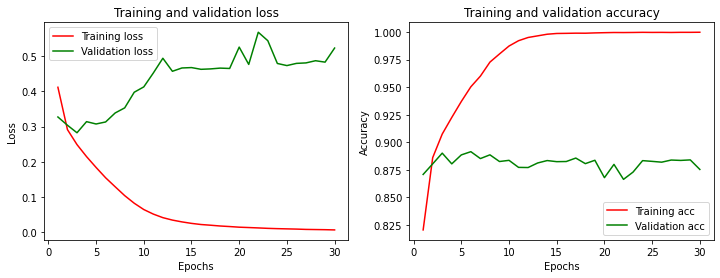

****************************************************************************************************
****************************************************************************************************
@@@ Training for adadelta for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7]
training accuracy=
[0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.58, 0.59, 0.6, 0.61, 0.62, 0.62, 0.63, 0.64, 0.65, 0.66, 0.66, 0.67, 0.67, 0.68, 0.69, 0.69, 0.69, 0.7, 0.7, 0.7, 0.71, 0.71, 0.71]
validation accuracy=
[0.51, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.59, 0.6, 0.6, 0.61, 0.62, 0.62, 0.63, 0.64, 0.64, 0.65, 0.65, 0.66, 0.66, 0.67, 0.67, 0

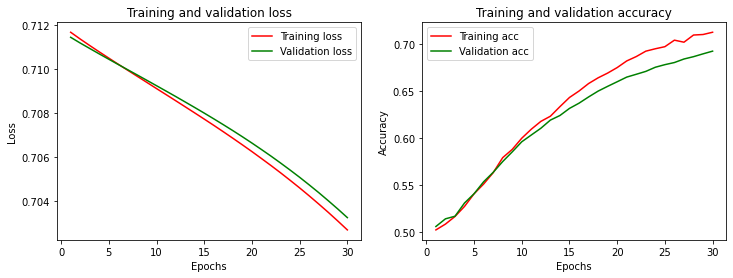

****************************************************************************************************
****************************************************************************************************
@@@ Training for adam for lr= 0.001

Train...

*********

training loss=
[0.39, 0.24, 0.16, 0.1, 0.06, 0.04, 0.04, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
validation loss=
[0.33, 0.3, 0.32, 0.36, 0.42, 0.46, 0.49, 0.49, 0.51, 0.51, 0.5, 0.53, 0.54, 0.52, 0.54, 0.53, 0.55, 0.57, 0.58, 0.57, 0.6, 0.59, 0.63, 0.58, 0.61, 0.61, 0.59, 0.6, 0.6, 0.62]
training accuracy=
[0.83, 0.91, 0.95, 0.98, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.86, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86, 0.87, 0.86, 0.86, 0.86, 0.86

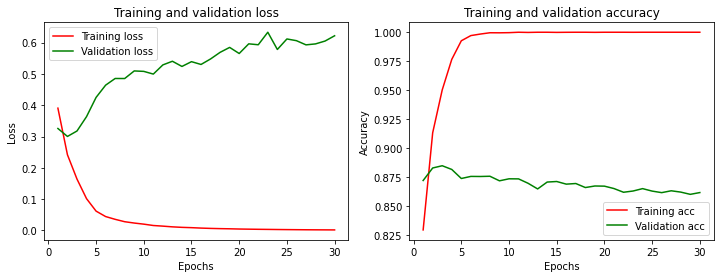

****************************************************************************************************
****************************************************************************************************


In [ ]:
# remaining part of the above cell

# model having 2 different cnn layer with gfrid 3,4
batch_size = 8
epoch = 30
print("Training is being done for bathch size= {}, for  {} epochs".format(batch_size,epoch) )

l=["sgd","sgd_mntm","adagrad","rmsprop","adadelta","adam"]
for name_of_optim in l:
    for lr in [0.001]:
        print("@@@ Training for {} for lr= {}".format(name_of_optim,lr))
        training(name_of_optim,lr,epoch,batch_size)
    print("*"*100)
    print("*"*100)

Training is being done for bathch size= 32, for  30 epochs
@@@ Training for sgd for lr= 0.1

Train...

*********

training loss=
[0.7, 0.64, 0.57, 0.5, 0.46, 0.42, 0.39, 0.36, 0.34, 0.32, 0.31, 0.29, 0.28, 0.26, 0.25, 0.23, 0.22, 0.21, 0.19, 0.18, 0.17, 0.16, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.08]
validation loss=
[0.68, 0.61, 0.54, 0.5, 0.45, 0.43, 0.4, 0.38, 0.37, 0.38, 0.4, 0.37, 0.36, 0.39, 0.35, 0.37, 0.35, 0.36, 0.39, 0.42, 0.39, 0.39, 0.4, 0.45, 0.44, 0.46, 0.47, 0.47, 0.48, 0.51]
training accuracy=
[0.55, 0.64, 0.72, 0.77, 0.79, 0.82, 0.83, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.9, 0.91, 0.92, 0.93, 0.93, 0.94, 0.95, 0.95, 0.95, 0.96, 0.97, 0.97, 0.98, 0.98, 0.99, 0.99, 0.99]
validation accuracy=
[0.55, 0.7, 0.74, 0.76, 0.8, 0.81, 0.83, 0.84, 0.85, 0.84, 0.83, 0.85, 0.85, 0.84, 0.86, 0.86, 0.86, 0.86, 0.85, 0.85, 0.86, 0.86, 0.86, 0.85, 0.86, 0.85, 0.85, 0.86, 0.86, 0.85]

*********

_________________________________________________________________________________________

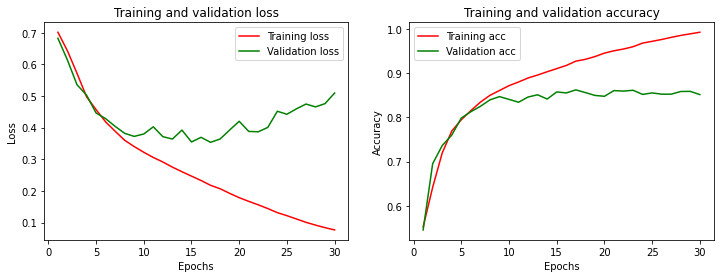

@@@ Training for sgd for lr= 0.01

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.69, 0.68, 0.67, 0.66, 0.66, 0.66, 0.66, 0.65, 0.65, 0.64, 0.63, 0.63, 0.62, 0.61, 0.6, 0.59, 0.57, 0.56, 0.56, 0.55, 0.55, 0.54, 0.54]
validation loss=
[0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.69, 0.69, 0.68, 0.67, 0.66, 0.66, 0.66, 0.66, 0.65, 0.65, 0.64, 0.63, 0.63, 0.62, 0.61, 0.6, 0.58, 0.57, 0.56, 0.55, 0.55, 0.54, 0.54, 0.54]
training accuracy=
[0.51, 0.53, 0.56, 0.59, 0.6, 0.62, 0.65, 0.65, 0.62, 0.6, 0.6, 0.6, 0.6, 0.6, 0.61, 0.62, 0.65, 0.67, 0.66, 0.66, 0.67, 0.69, 0.7, 0.71, 0.72, 0.72, 0.73, 0.74, 0.74, 0.74]
validation accuracy=
[0.51, 0.54, 0.59, 0.62, 0.54, 0.65, 0.66, 0.64, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.61, 0.63, 0.66, 0.65, 0.65, 0.66, 0.67, 0.69, 0.7, 0.71, 0.72, 0.73, 0.73, 0.73, 0.74, 0.74]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 5ms

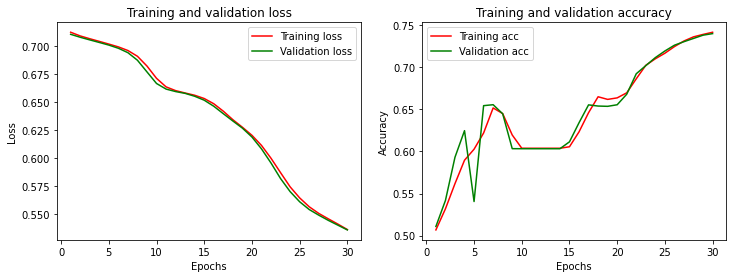

@@@ Training for sgd for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.51, 0.51, 0.52, 0.53, 0.53, 0.53, 0.54, 0.54, 0.55, 0.55, 0.56, 0.56, 0.57, 0.57, 0.58, 0.58, 0.58, 0.59, 0.6, 0.6, 0.6, 0.6, 0.61, 0.61, 0.61, 0.62]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.51, 0.51, 0.51, 0.52, 0.52, 0.53, 0.53, 0.54, 0.54, 0.54, 0.55, 0.55, 0.56, 0.56, 0.56, 0.57, 0.57, 0.57, 0.58, 0.58, 0.58, 0.59, 0.59, 0.59, 0.59, 0.6]

*********

____________________________________________________________________________________________________

Test...
313/313 [=============================

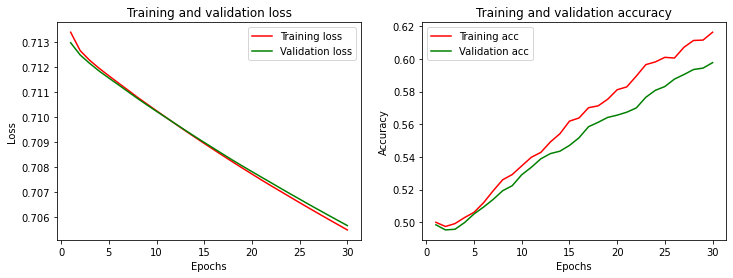

****************************************************************************************************
****************************************************************************************************
@@@ Training for sgd_mntm for lr= 0.1

Train...

*********

training loss=
[0.58, 0.41, 0.34, 0.3, 0.27, 0.25, 0.22, 0.2, 0.17, 0.16, 0.13, 0.12, 0.1, 0.09, 0.08, 0.08, 0.06, 0.06, 0.05, 0.04, 0.05, 0.04, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01]
validation loss=
[0.45, 0.37, 0.37, 0.34, 0.37, 0.36, 0.4, 0.42, 0.4, 0.47, 0.49, 0.52, 0.51, 0.56, 0.61, 0.6, 0.69, 0.71, 0.8, 0.87, 0.82, 0.84, 0.9, 0.83, 0.75, 0.69, 0.65, 0.63, 0.63, 0.63]
training accuracy=
[0.68, 0.82, 0.86, 0.88, 0.89, 0.9, 0.91, 0.93, 0.94, 0.94, 0.95, 0.96, 0.97, 0.97, 0.98, 0.98, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.79, 0.84, 0.84, 0.85, 0.85, 0.85, 0.84, 0.85, 0.85, 0.83, 0.84, 0.86, 0.85, 0.85, 0.85, 0.86, 0.85, 0.85, 0.85, 0.84, 0.85, 0.86, 0.85,

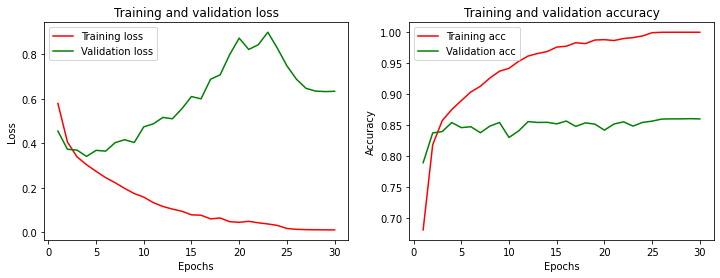

@@@ Training for sgd_mntm for lr= 0.01

Train...

*********

training loss=
[0.7, 0.67, 0.61, 0.53, 0.48, 0.45, 0.42, 0.38, 0.35, 0.33, 0.31, 0.29, 0.28, 0.26, 0.24, 0.23, 0.21, 0.19, 0.18, 0.17, 0.15, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.08, 0.07]
validation loss=
[0.7, 0.64, 0.56, 0.5, 0.47, 0.44, 0.42, 0.4, 0.39, 0.38, 0.37, 0.37, 0.38, 0.36, 0.36, 0.37, 0.38, 0.38, 0.4, 0.4, 0.42, 0.42, 0.44, 0.45, 0.46, 0.5, 0.49, 0.53, 0.52, 0.55]
training accuracy=
[0.53, 0.6, 0.68, 0.74, 0.77, 0.8, 0.82, 0.84, 0.85, 0.87, 0.88, 0.89, 0.89, 0.91, 0.91, 0.92, 0.93, 0.94, 0.94, 0.95, 0.96, 0.96, 0.97, 0.97, 0.98, 0.98, 0.98, 0.99, 0.99, 0.99]
validation accuracy=
[0.51, 0.6, 0.72, 0.76, 0.78, 0.8, 0.82, 0.83, 0.83, 0.84, 0.84, 0.84, 0.84, 0.85, 0.85, 0.86, 0.85, 0.86, 0.85, 0.85, 0.85, 0.86, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85]

*********

____________________________________________________________________________________________________

Test...
313/313 [========================

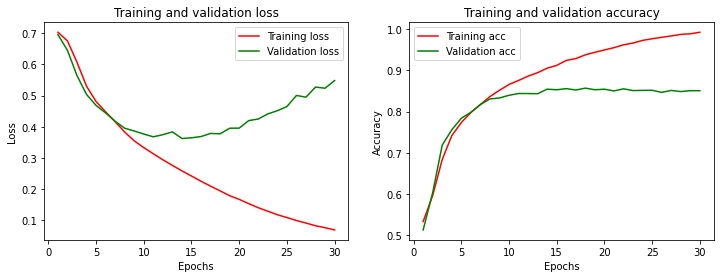

@@@ Training for sgd_mntm for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.68, 0.67, 0.66, 0.65, 0.64, 0.64, 0.63, 0.63, 0.62, 0.61, 0.6, 0.59, 0.59, 0.58, 0.58, 0.58, 0.57]
validation loss=
[0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.68, 0.67, 0.66, 0.65, 0.64, 0.64, 0.63, 0.63, 0.62, 0.61, 0.6, 0.59, 0.59, 0.58, 0.58, 0.58, 0.57]
training accuracy=
[0.51, 0.54, 0.57, 0.57, 0.61, 0.63, 0.63, 0.62, 0.65, 0.66, 0.67, 0.67, 0.65, 0.65, 0.64, 0.63, 0.63, 0.63, 0.64, 0.65, 0.66, 0.66, 0.67, 0.68, 0.69, 0.69, 0.7, 0.7, 0.7, 0.7]
validation accuracy=
[0.52, 0.52, 0.55, 0.6, 0.63, 0.62, 0.59, 0.6, 0.65, 0.67, 0.67, 0.64, 0.65, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.65, 0.65, 0.66, 0.67, 0.68, 0.68, 0.69, 0.69, 0.69, 0.7, 0.7]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1

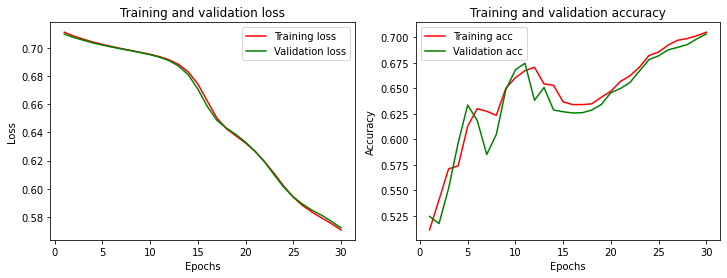

****************************************************************************************************
****************************************************************************************************
@@@ Training for adagrad for lr= 0.1

Train...

*********

training loss=
[0.66, 0.48, 0.4, 0.35, 0.32, 0.29, 0.26, 0.24, 0.21, 0.19, 0.17, 0.15, 0.13, 0.11, 0.1, 0.08, 0.07, 0.06, 0.06, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03]
validation loss=
[0.55, 0.44, 0.39, 0.36, 0.34, 0.34, 0.33, 0.33, 0.33, 0.34, 0.35, 0.36, 0.37, 0.39, 0.39, 0.41, 0.42, 0.43, 0.45, 0.47, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.52, 0.53, 0.53, 0.54]
training accuracy=
[0.61, 0.77, 0.82, 0.85, 0.87, 0.88, 0.9, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.98, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.71, 0.8, 0.83, 0.85, 0.86, 0.86, 0.86, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.8

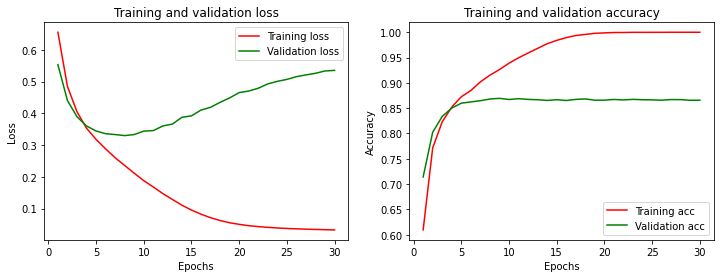

@@@ Training for adagrad for lr= 0.01

Train...

*********

training loss=
[0.71, 0.7, 0.7, 0.69, 0.67, 0.63, 0.61, 0.59, 0.57, 0.56, 0.54, 0.53, 0.51, 0.5, 0.48, 0.47, 0.46, 0.46, 0.45, 0.44, 0.43, 0.43, 0.42, 0.42, 0.41, 0.4, 0.39, 0.39, 0.38, 0.38]
validation loss=
[0.71, 0.7, 0.7, 0.69, 0.65, 0.62, 0.59, 0.58, 0.56, 0.55, 0.54, 0.52, 0.51, 0.49, 0.48, 0.48, 0.47, 0.46, 0.46, 0.45, 0.45, 0.44, 0.44, 0.43, 0.43, 0.42, 0.42, 0.41, 0.41, 0.4]
training accuracy=
[0.53, 0.6, 0.63, 0.65, 0.68, 0.66, 0.68, 0.7, 0.72, 0.73, 0.73, 0.74, 0.76, 0.77, 0.78, 0.78, 0.79, 0.8, 0.8, 0.8, 0.81, 0.81, 0.82, 0.82, 0.83, 0.83, 0.83, 0.84, 0.84, 0.85]
validation accuracy=
[0.6, 0.64, 0.6, 0.66, 0.69, 0.67, 0.69, 0.72, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.77, 0.78, 0.78, 0.79, 0.79, 0.8, 0.8, 0.8, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.83, 0.83]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================

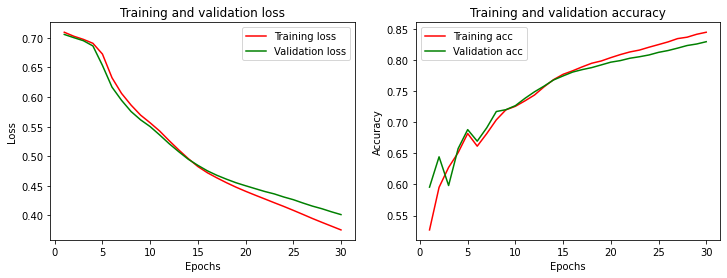

@@@ Training for adagrad for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
training accuracy=
[0.51, 0.53, 0.56, 0.57, 0.59, 0.6, 0.6, 0.61, 0.62, 0.63, 0.64, 0.64, 0.65, 0.65, 0.66, 0.66, 0.66, 0.66, 0.67, 0.66, 0.67, 0.67, 0.67, 0.67, 0.67, 0.68, 0.68, 0.68, 0.68, 0.68]
validation accuracy=
[0.51, 0.54, 0.56, 0.57, 0.58, 0.59, 0.59, 0.6, 0.61, 0.61, 0.62, 0.62, 0.63, 0.63, 0.63, 0.64, 0.64, 0.64, 0.64, 0.64, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.66, 0.66, 0.66, 0.66]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 5ms/step - loss

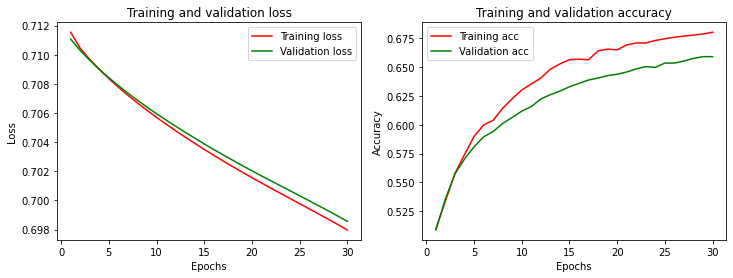

****************************************************************************************************
****************************************************************************************************
@@@ Training for rmsprop for lr= 0.1

Train...

*********

training loss=
[3.02, 1.41, 1.15, 1.22, 1.16, 0.98, 0.93, 0.96, 0.89, 0.87, 0.86, 0.81, 0.9, 0.88, 0.95, 0.79, 0.85, 0.8, 0.77, 0.84, 0.8, 0.74, 0.74, 0.74, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72]
validation loss=
[1.69, 1.09, 0.92, 1.01, 1.18, 0.88, 0.95, 0.9, 0.77, 0.82, 0.8, 0.8, 0.85, 0.82, 0.73, 0.72, 0.77, 0.77, 0.73, 0.77, 0.74, 0.74, 0.72, 0.71, 0.72, 0.73, 0.72, 0.72, 0.71, 0.71]
training accuracy=
[0.51, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

****

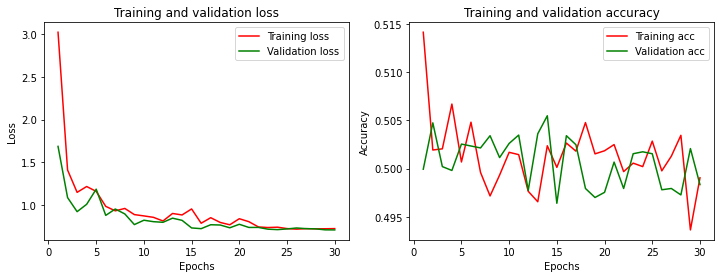

@@@ Training for rmsprop for lr= 0.01

Train...

*********

training loss=
[0.43, 0.31, 0.25, 0.19, 0.14, 0.1, 0.07, 0.05, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.02, 0.02]
validation loss=
[0.35, 0.34, 0.41, 0.44, 0.57, 0.65, 1.1, 1.01, 1.24, 1.27, 1.3, 1.31, 1.25, 1.27, 1.3, 1.11, 1.47, 1.02, 1.05, 1.36, 1.08, 0.99, 1.07, 1.27, 1.2, 1.03, 0.87, 1.56, 1.01, 1.02]
training accuracy=
[0.81, 0.88, 0.91, 0.93, 0.95, 0.97, 0.98, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.86, 0.87, 0.85, 0.86, 0.85, 0.86, 0.84, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.84, 0.86, 0.86, 0.85, 0.86, 0.86, 0.86, 0.84, 0.85, 0.86, 0.86, 0.82, 0.86, 0.86]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1s 5

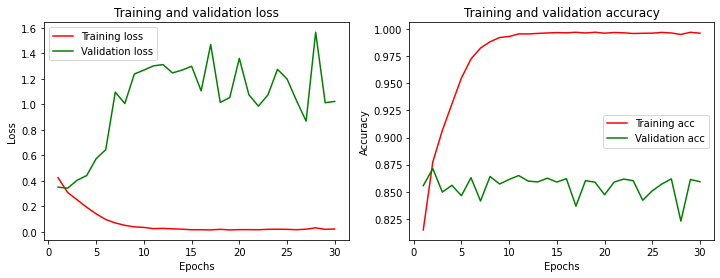

@@@ Training for rmsprop for lr= 0.001

Train...

*********

training loss=
[0.45, 0.3, 0.25, 0.22, 0.19, 0.16, 0.14, 0.11, 0.1, 0.08, 0.07, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
validation loss=
[0.36, 0.31, 0.3, 0.3, 0.29, 0.29, 0.31, 0.31, 0.32, 0.33, 0.34, 0.37, 0.39, 0.38, 0.43, 0.39, 0.39, 0.39, 0.43, 0.4, 0.41, 0.41, 0.43, 0.46, 0.42, 0.43, 0.43, 0.44, 0.43, 0.44]
training accuracy=
[0.8, 0.89, 0.91, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.86, 0.88, 0.89, 0.89, 0.89, 0.9, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.88, 0.89, 0.87, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 

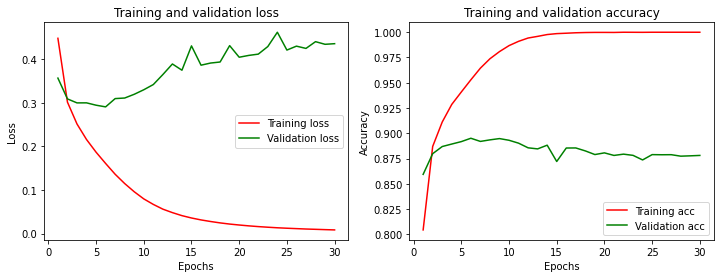

****************************************************************************************************
****************************************************************************************************
@@@ Training for adadelta for lr= 0.1

Train...

*********

training loss=
[0.71, 0.69, 0.64, 0.59, 0.56, 0.52, 0.49, 0.47, 0.46, 0.44, 0.43, 0.42, 0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.35, 0.34, 0.33, 0.32, 0.32, 0.31, 0.31, 0.3, 0.3, 0.29, 0.29, 0.28]
validation loss=
[0.7, 0.66, 0.61, 0.58, 0.54, 0.51, 0.48, 0.47, 0.46, 0.44, 0.43, 0.42, 0.42, 0.41, 0.4, 0.39, 0.38, 0.38, 0.37, 0.37, 0.36, 0.36, 0.35, 0.35, 0.35, 0.34, 0.34, 0.34, 0.34, 0.33]
training accuracy=
[0.57, 0.67, 0.7, 0.71, 0.73, 0.76, 0.78, 0.79, 0.8, 0.81, 0.82, 0.82, 0.83, 0.84, 0.85, 0.85, 0.86, 0.86, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.9, 0.9]
validation accuracy=
[0.65, 0.69, 0.7, 0.71, 0.74, 0.76, 0.78, 0.79, 0.8, 0.8, 0.81, 0.82, 0.82, 0.83, 0.84, 0.84, 0.84, 0.85, 0.85, 0.85, 0.85, 0.86, 0.

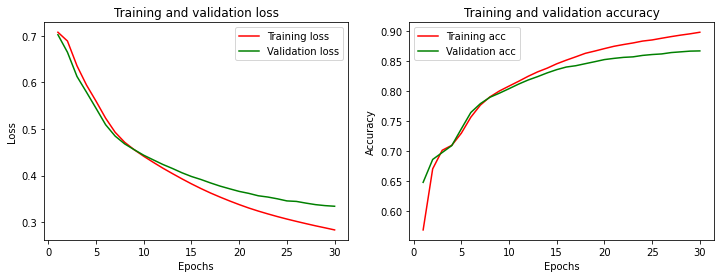

@@@ Training for adadelta for lr= 0.01

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.68, 0.68, 0.67, 0.66, 0.66, 0.65, 0.65, 0.64, 0.64, 0.63, 0.63, 0.62, 0.62, 0.61]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.68, 0.68, 0.67, 0.67, 0.66, 0.66, 0.65, 0.65, 0.64, 0.64, 0.63, 0.63, 0.62, 0.62, 0.61]
training accuracy=
[0.51, 0.55, 0.58, 0.62, 0.64, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.72, 0.72, 0.73, 0.72, 0.72, 0.72, 0.7, 0.7, 0.68, 0.68, 0.67, 0.67, 0.68, 0.68, 0.69, 0.69, 0.7, 0.7, 0.7]
validation accuracy=
[0.53, 0.56, 0.59, 0.62, 0.64, 0.66, 0.67, 0.68, 0.7, 0.7, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.68, 0.68, 0.67, 0.67, 0.67, 0.67, 0.68, 0.68, 0.69, 0.69, 0.69, 0.7]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2

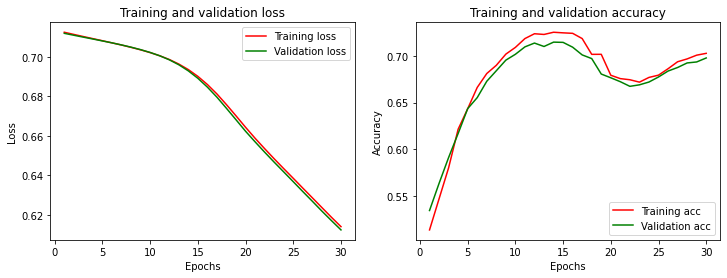

@@@ Training for adadelta for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.51, 0.52, 0.52, 0.52, 0.53, 0.53, 0.54, 0.54, 0.54, 0.55, 0.55, 0.56, 0.56, 0.57, 0.57, 0.57]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.51, 0.52, 0.52, 0.53, 0.53, 0.53, 0.54, 0.54, 0.54, 0.55, 0.55, 0.55, 0.56, 0.56]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 6m

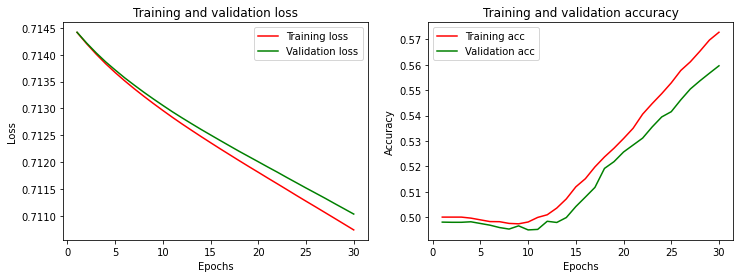

****************************************************************************************************
****************************************************************************************************
@@@ Training for adam for lr= 0.1

Train...

*********

training loss=
[3.12, 4.62, 1.98, 4.38, 0.94, 0.84, 0.79, 0.77, 0.78, 0.72, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
validation loss=
[1.24, 2.71, 1.17, 1.05, 0.88, 0.81, 0.85, 0.73, 0.74, 0.71, 0.7, 0.7, 0.69, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
training accuracy=
[0.51, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.5, 0.49, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

___________________________

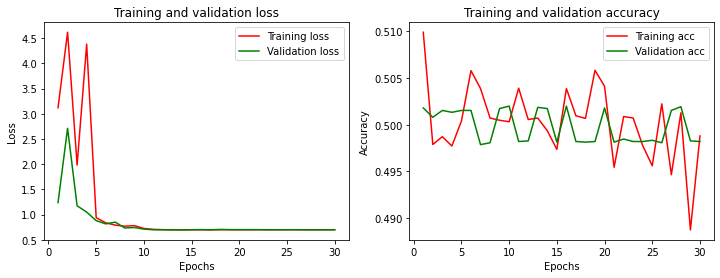

@@@ Training for adam for lr= 0.01

Train...

*********

training loss=
[0.41, 0.3, 0.24, 0.17, 0.16, 0.12, 0.12, 0.18, 0.12, 0.12, 0.17, 0.16, 0.12, 0.1, 0.18, 0.16, 0.11, 0.14, 0.16, 0.17, 0.2, 0.18, 0.19, 0.15, 0.22, 0.17, 0.15, 0.19, 0.21, 0.14]
validation loss=
[0.41, 0.34, 0.4, 0.51, 0.65, 0.71, 0.88, 0.96, 1.05, 1.34, 1.6, 1.76, 1.8, 2.08, 2.21, 2.39, 2.41, 2.84, 3.71, 3.98, 4.21, 5.18, 4.54, 4.94, 5.75, 5.62, 6.14, 6.34, 6.27, 6.76]
training accuracy=
[0.83, 0.88, 0.91, 0.94, 0.95, 0.96, 0.97, 0.96, 0.97, 0.98, 0.97, 0.97, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]
validation accuracy=
[0.83, 0.86, 0.86, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.84, 0.85, 0.86, 0.85, 0.85, 0.85, 0.86, 0.83, 0.85, 0.85, 0.84, 0.85, 0.85, 0.86, 0.85, 0.85, 0.85, 0.85, 0.85]

*********

____________________________________________________________________________________________________

Test...
313/313 [======================

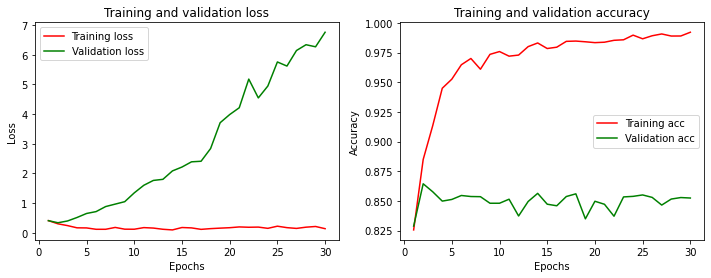

@@@ Training for adam for lr= 0.001

Train...

*********

training loss=
[0.44, 0.27, 0.2, 0.15, 0.1, 0.07, 0.05, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
validation loss=
[0.33, 0.31, 0.32, 0.34, 0.39, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.51, 0.5, 0.52, 0.53, 0.54, 0.54, 0.55, 0.56, 0.57, 0.58, 0.58, 0.59, 0.58, 0.6, 0.61, 0.61, 0.61, 0.63, 0.63]
training accuracy=
[0.81, 0.9, 0.94, 0.96, 0.98, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.87, 0.88, 0.88, 0.88, 0.88, 0.87, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1s 5ms/step - lo

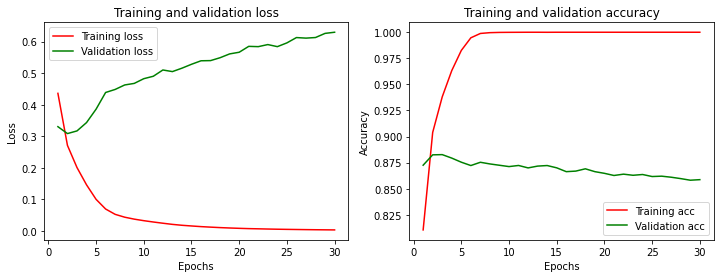

****************************************************************************************************
****************************************************************************************************


In [ ]:
# model having 2 different cnn layer with gfrid 3,4
batch_size = 32
epoch = 30
print("Training is being done for bathch size= {}, for  {} epochs".format(batch_size,epoch) )

l=["sgd","sgd_mntm","adagrad","rmsprop","adadelta","adam"]
for name_of_optim in l:
    for lr in [0.1,0.01,0.001]:
        print("@@@ Training for {} for lr= {}".format(name_of_optim,lr))
        training(name_of_optim,lr,epoch,batch_size)
    print("*"*100)
    print("*"*100)

Training is being done for bathch size= 128, for  30 epochs
@@@ Training for sgd for lr= 0.1

Train...

*********

training loss=
[0.71, 0.7, 0.7, 0.69, 0.68, 0.65, 0.64, 0.64, 0.63, 0.61, 0.6, 0.57, 0.54, 0.52, 0.5, 0.49, 0.49, 0.48, 0.47, 0.46, 0.45, 0.45, 0.44, 0.43, 0.43, 0.42, 0.41, 0.4, 0.39, 0.39]
validation loss=
[0.71, 0.7, 0.7, 0.69, 0.66, 0.65, 0.64, 0.64, 0.62, 0.61, 0.59, 0.56, 0.53, 0.51, 0.51, 0.5, 0.5, 0.49, 0.48, 0.48, 0.47, 0.47, 0.46, 0.46, 0.45, 0.44, 0.44, 0.43, 0.44, 0.43]
training accuracy=
[0.52, 0.57, 0.6, 0.61, 0.62, 0.64, 0.64, 0.64, 0.65, 0.67, 0.7, 0.72, 0.74, 0.75, 0.76, 0.77, 0.78, 0.78, 0.79, 0.79, 0.8, 0.8, 0.8, 0.81, 0.81, 0.82, 0.82, 0.83, 0.83, 0.83]
validation accuracy=
[0.58, 0.53, 0.57, 0.6, 0.64, 0.63, 0.63, 0.64, 0.66, 0.69, 0.7, 0.73, 0.74, 0.76, 0.76, 0.77, 0.77, 0.77, 0.78, 0.78, 0.78, 0.79, 0.79, 0.79, 0.8, 0.8, 0.8, 0.81, 0.81, 0.81]

*********

________________________________________________________________________________________________

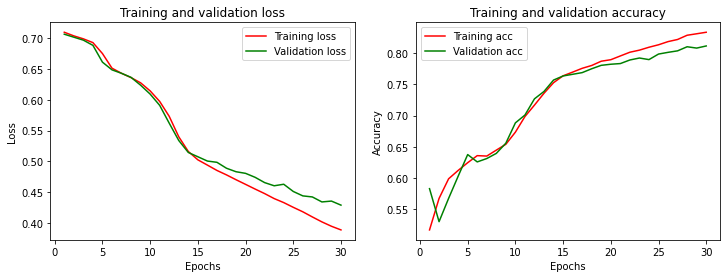

@@@ Training for sgd for lr= 0.01

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
training accuracy=
[0.51, 0.51, 0.52, 0.53, 0.55, 0.56, 0.57, 0.56, 0.59, 0.59, 0.58, 0.61, 0.61, 0.62, 0.62, 0.64, 0.64, 0.64, 0.65, 0.64, 0.65, 0.65, 0.66, 0.66, 0.66, 0.67, 0.67, 0.66, 0.68, 0.68]
validation accuracy=
[0.5, 0.51, 0.51, 0.54, 0.54, 0.54, 0.54, 0.57, 0.58, 0.58, 0.59, 0.6, 0.59, 0.61, 0.61, 0.62, 0.61, 0.62, 0.6, 0.63, 0.64, 0.64, 0.62, 0.62, 0.64, 0.64, 0.64, 0.66, 0.65, 0.65]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1s 4ms/step - loss: 0.

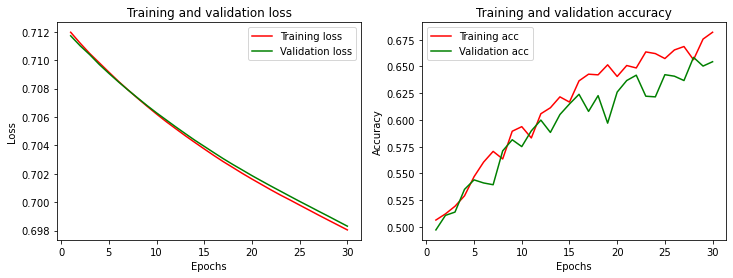

@@@ Training for sgd for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
training accuracy=
[0.5, 0.5, 0.51, 0.51, 0.52, 0.52, 0.52, 0.52, 0.53, 0.53, 0.53, 0.53, 0.54, 0.54, 0.54, 0.54, 0.54, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56]
validation accuracy=
[0.5, 0.51, 0.51, 0.51, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55]

*********

____________________________________________________________________________________________________

Test...
313/313 [===================

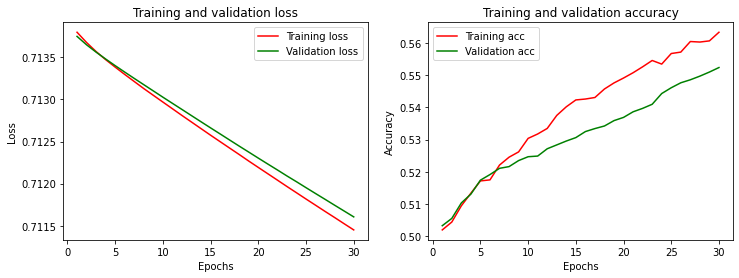

****************************************************************************************************
****************************************************************************************************
@@@ Training for sgd_mntm for lr= 0.1

Train...

*********

training loss=
[0.69, 0.54, 0.45, 0.39, 0.34, 0.31, 0.28, 0.25, 0.23, 0.21, 0.18, 0.16, 0.14, 0.12, 0.1, 0.09, 0.07, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
validation loss=
[0.63, 0.48, 0.43, 0.38, 0.36, 0.39, 0.34, 0.34, 0.35, 0.36, 0.37, 0.44, 0.42, 0.44, 0.47, 0.54, 0.55, 0.57, 0.6, 0.6, 0.61, 0.62, 0.62, 0.61, 0.61, 0.62, 0.61, 0.61, 0.61, 0.61]
training accuracy=
[0.56, 0.73, 0.8, 0.83, 0.86, 0.88, 0.89, 0.9, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.97, 0.98, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.66, 0.78, 0.81, 0.83, 0.85, 0.84, 0.86, 0.86, 0.86, 0.86, 0.86, 0.85, 0.86, 0.86, 0.86, 0.85, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0

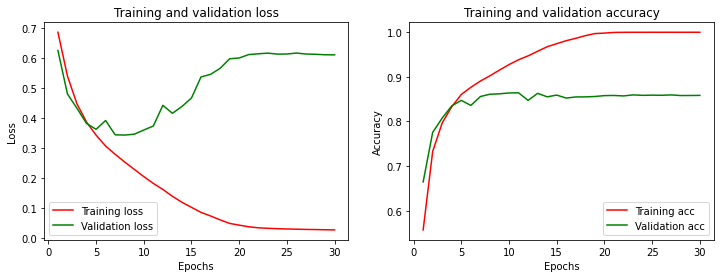

@@@ Training for sgd_mntm for lr= 0.01

Train...

*********

training loss=
[0.71, 0.7, 0.7, 0.69, 0.67, 0.65, 0.63, 0.62, 0.61, 0.59, 0.57, 0.56, 0.54, 0.53, 0.51, 0.5, 0.49, 0.48, 0.47, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4, 0.39, 0.38, 0.37, 0.37, 0.36]
validation loss=
[0.71, 0.7, 0.7, 0.68, 0.66, 0.64, 0.62, 0.61, 0.6, 0.58, 0.57, 0.55, 0.54, 0.52, 0.51, 0.5, 0.49, 0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.42, 0.42, 0.41, 0.41, 0.4, 0.4]
training accuracy=
[0.52, 0.54, 0.57, 0.66, 0.62, 0.61, 0.65, 0.67, 0.68, 0.7, 0.71, 0.73, 0.74, 0.75, 0.76, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.81, 0.82, 0.83, 0.83, 0.84, 0.84, 0.85, 0.85, 0.86]
validation accuracy=
[0.5, 0.5, 0.58, 0.63, 0.6, 0.65, 0.66, 0.66, 0.68, 0.7, 0.72, 0.73, 0.74, 0.75, 0.76, 0.76, 0.77, 0.77, 0.78, 0.79, 0.8, 0.8, 0.81, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.83]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================

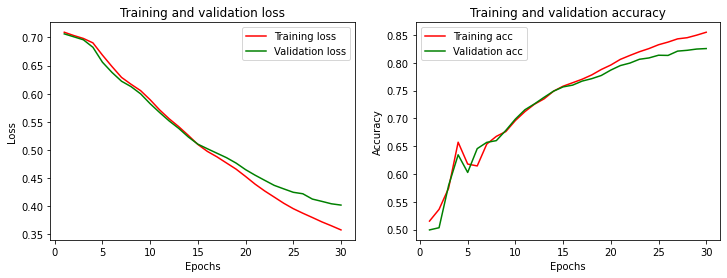

@@@ Training for sgd_mntm for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69]
training accuracy=
[0.5, 0.51, 0.52, 0.54, 0.55, 0.54, 0.57, 0.57, 0.58, 0.6, 0.58, 0.61, 0.63, 0.63, 0.63, 0.64, 0.65, 0.66, 0.66, 0.67, 0.66, 0.66, 0.67, 0.67, 0.67, 0.68, 0.68, 0.67, 0.67, 0.68]
validation accuracy=
[0.51, 0.52, 0.53, 0.54, 0.55, 0.57, 0.58, 0.59, 0.59, 0.59, 0.61, 0.62, 0.62, 0.61, 0.64, 0.64, 0.65, 0.65, 0.64, 0.64, 0.63, 0.66, 0.65, 0.65, 0.67, 0.67, 0.67, 0.65, 0.67, 0.66]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1s 4ms/step

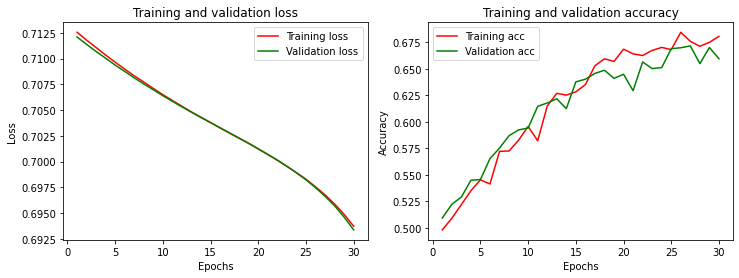

****************************************************************************************************
****************************************************************************************************
@@@ Training for adagrad for lr= 0.1

Train...

*********

training loss=
[0.7, 0.69, 0.65, 0.6, 0.56, 0.53, 0.47, 0.43, 0.41, 0.38, 0.36, 0.34, 0.33, 0.31, 0.3, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23, 0.22, 0.21, 0.2, 0.19, 0.18, 0.17, 0.16, 0.15, 0.14]
validation loss=
[0.7, 0.68, 0.62, 0.6, 0.55, 0.51, 0.46, 0.44, 0.42, 0.4, 0.39, 0.38, 0.37, 0.36, 0.36, 0.37, 0.36, 0.35, 0.35, 0.35, 0.35, 0.35, 0.36, 0.37, 0.36, 0.36, 0.37, 0.37, 0.37, 0.38]
training accuracy=
[0.53, 0.6, 0.64, 0.69, 0.72, 0.75, 0.78, 0.81, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.88, 0.89, 0.9, 0.9, 0.91, 0.92, 0.92, 0.93, 0.93, 0.94, 0.94, 0.95, 0.95, 0.95, 0.96, 0.96]
validation accuracy=
[0.6, 0.62, 0.65, 0.69, 0.73, 0.76, 0.79, 0.8, 0.81, 0.83, 0.83, 0.84, 0.84, 0.85, 0.85, 0.85, 0.85, 0.85, 0.86, 0.86, 0.86, 0.86, 0.8

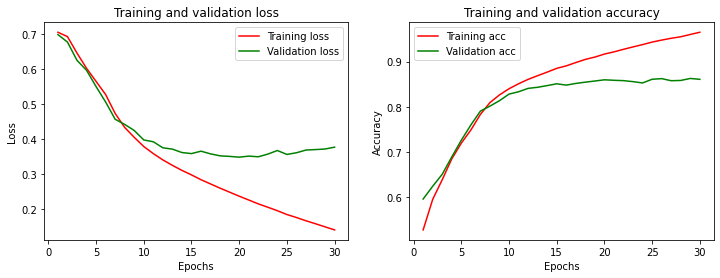

@@@ Training for adagrad for lr= 0.01

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.68, 0.68, 0.67, 0.66, 0.66, 0.66, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.63, 0.62, 0.62, 0.61, 0.61, 0.6, 0.6, 0.59]
validation loss=
[0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.68, 0.67, 0.66, 0.66, 0.66, 0.66, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.62, 0.62, 0.61, 0.61, 0.61, 0.6, 0.6, 0.59]
training accuracy=
[0.51, 0.54, 0.55, 0.58, 0.62, 0.61, 0.65, 0.66, 0.66, 0.66, 0.63, 0.62, 0.6, 0.6, 0.61, 0.62, 0.63, 0.63, 0.64, 0.65, 0.65, 0.66, 0.67, 0.67, 0.67, 0.67, 0.68, 0.68, 0.69, 0.7]
validation accuracy=
[0.51, 0.54, 0.53, 0.59, 0.61, 0.63, 0.66, 0.66, 0.66, 0.64, 0.64, 0.6, 0.6, 0.6, 0.61, 0.62, 0.62, 0.63, 0.64, 0.64, 0.65, 0.66, 0.66, 0.66, 0.67, 0.67, 0.68, 0.69, 0.69, 0.7]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] -

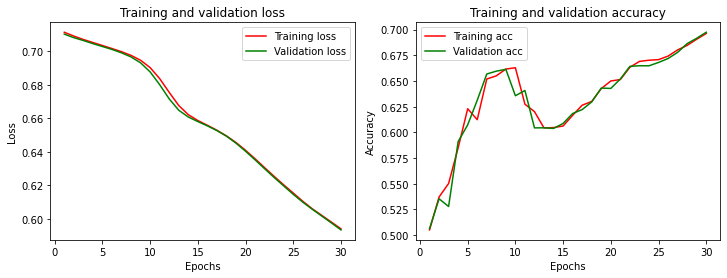

@@@ Training for adagrad for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
training accuracy=
[0.5, 0.5, 0.51, 0.52, 0.53, 0.53, 0.54, 0.54, 0.55, 0.55, 0.55, 0.56, 0.56, 0.57, 0.57, 0.57, 0.57, 0.58, 0.58, 0.59, 0.59, 0.59, 0.59, 0.6, 0.6, 0.6, 0.6, 0.61, 0.61, 0.61]
validation accuracy=
[0.5, 0.5, 0.51, 0.52, 0.53, 0.54, 0.54, 0.54, 0.55, 0.55, 0.55, 0.56, 0.56, 0.56, 0.57, 0.57, 0.57, 0.58, 0.58, 0.58, 0.58, 0.59, 0.59, 0.59, 0.59, 0.6, 0.6, 0.6, 0.6, 0.6]

*********

____________________________________________________________________________________________________

Test...
313/313 [=========================

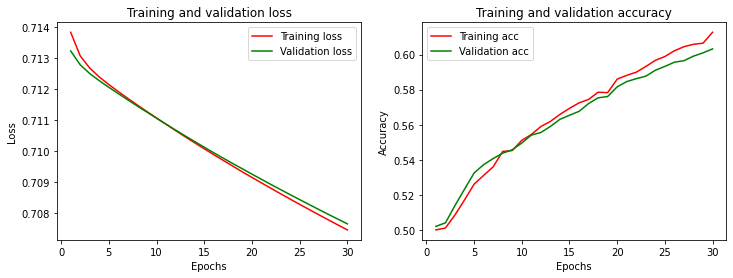

****************************************************************************************************
****************************************************************************************************
@@@ Training for rmsprop for lr= 0.1

Train...

*********

training loss=
[6.71, 1.08, 1.26, 1.35, 1.27, 1.33, 1.21, 1.64, 1.32, 1.41, 1.24, 1.36, 1.38, 1.6, 1.6, 1.4, 1.37, 1.42, 1.35, 1.59, 1.35, 1.44, 1.38, 1.32, 1.5, 1.18, 1.44, 1.62, 1.17, 1.49]
validation loss=
[1.51, 1.01, 1.85, 1.08, 1.4, 1.28, 2.24, 1.48, 2.1, 2.66, 2.05, 2.73, 3.14, 4.11, 5.0, 3.44, 3.61, 5.41, 5.97, 4.6, 5.76, 9.66, 4.93, 5.99, 6.31, 4.96, 8.9, 9.46, 7.67, 13.62]
training accuracy=
[0.62, 0.62, 0.62, 0.61, 0.62, 0.61, 0.66, 0.65, 0.65, 0.65, 0.67, 0.65, 0.65, 0.64, 0.65, 0.65, 0.65, 0.64, 0.65, 0.64, 0.64, 0.63, 0.64, 0.65, 0.65, 0.66, 0.63, 0.64, 0.65, 0.66]
validation accuracy=
[0.61, 0.63, 0.59, 0.64, 0.61, 0.65, 0.63, 0.6, 0.64, 0.61, 0.56, 0.61, 0.61, 0.57, 0.64, 0.64, 0.61, 0.65, 0.59, 0.59, 0.58, 0.61, 

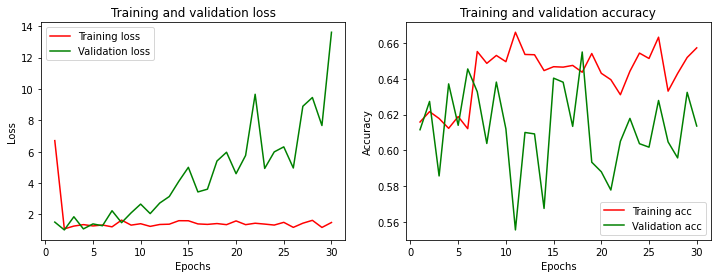

@@@ Training for rmsprop for lr= 0.01

Train...

*********

training loss=
[0.43, 0.3, 0.22, 0.15, 0.1, 0.06, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01]
validation loss=
[0.31, 0.35, 0.4, 0.44, 0.45, 0.82, 0.62, 0.64, 0.69, 0.71, 0.74, 0.72, 0.69, 0.65, 0.64, 0.62, 0.66, 1.65, 0.64, 0.65, 0.64, 0.98, 0.64, 0.65, 0.69, 0.75, 0.7, 0.7, 0.65, 0.71]
training accuracy=
[0.81, 0.88, 0.91, 0.95, 0.97, 0.98, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.88, 0.86, 0.86, 0.86, 0.87, 0.82, 0.87, 0.87, 0.86, 0.86, 0.87, 0.86, 0.86, 0.87, 0.86, 0.86, 0.86, 0.74, 0.86, 0.86, 0.86, 0.82, 0.86, 0.86, 0.85, 0.85, 0.86, 0.86, 0.86, 0.86]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1s 4ms

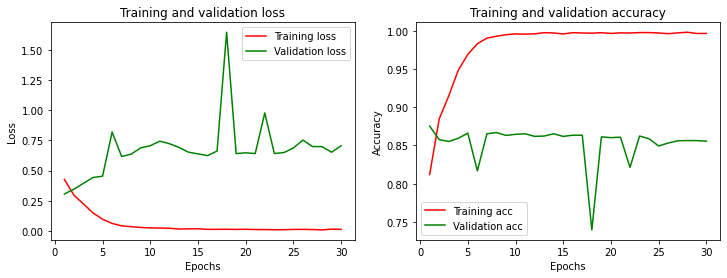

@@@ Training for rmsprop for lr= 0.001

Train...

*********

training loss=
[0.52, 0.34, 0.28, 0.24, 0.22, 0.19, 0.17, 0.15, 0.13, 0.11, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.05, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
validation loss=
[0.39, 0.33, 0.32, 0.32, 0.31, 0.32, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.39, 0.4, 0.43, 0.42, 0.42, 0.43, 0.43, 0.44, 0.44, 0.44, 0.44, 0.44, 0.46, 0.46, 0.45, 0.46, 0.46, 0.46]
training accuracy=
[0.77, 0.87, 0.9, 0.92, 0.93, 0.94, 0.96, 0.96, 0.97, 0.98, 0.98, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.84, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================]

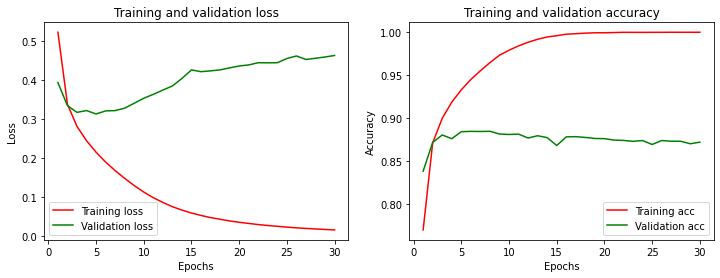

****************************************************************************************************
****************************************************************************************************
@@@ Training for adadelta for lr= 0.1

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.7, 0.7, 0.69, 0.67, 0.65, 0.63, 0.62, 0.61, 0.6, 0.58, 0.57, 0.56, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.51, 0.5, 0.49, 0.48, 0.48, 0.47, 0.46, 0.46, 0.45]
validation loss=
[0.71, 0.71, 0.7, 0.7, 0.69, 0.68, 0.66, 0.64, 0.63, 0.61, 0.6, 0.59, 0.58, 0.57, 0.56, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.51, 0.5, 0.49, 0.49, 0.48, 0.47, 0.47, 0.46, 0.46]
training accuracy=
[0.53, 0.61, 0.65, 0.66, 0.69, 0.69, 0.68, 0.68, 0.69, 0.69, 0.7, 0.7, 0.71, 0.72, 0.72, 0.73, 0.73, 0.74, 0.75, 0.76, 0.76, 0.77, 0.77, 0.78, 0.78, 0.79, 0.79, 0.79, 0.8, 0.8]
validation accuracy=
[0.58, 0.64, 0.63, 0.67, 0.68, 0.68, 0.67, 0.67, 0.68, 0.68, 0.69, 0.7, 0.71, 0.71, 0.72, 0.72, 0.73, 0.74, 0.74, 0.75, 0.76, 0.76, 0.7

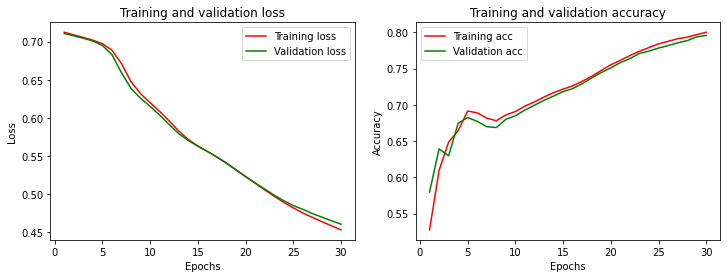

@@@ Training for adadelta for lr= 0.01

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7]
training accuracy=
[0.5, 0.5, 0.52, 0.54, 0.55, 0.57, 0.58, 0.58, 0.59, 0.6, 0.61, 0.61, 0.62, 0.63, 0.63, 0.63, 0.64, 0.65, 0.65, 0.65, 0.66, 0.66, 0.67, 0.67, 0.67, 0.67, 0.68, 0.68, 0.68, 0.68]
validation accuracy=
[0.5, 0.51, 0.52, 0.54, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.6, 0.61, 0.61, 0.62, 0.62, 0.62, 0.63, 0.63, 0.63, 0.64, 0.64, 0.64, 0.65, 0.65, 0.65, 0.65, 0.65, 0.66, 0.66]

*********

____________________________________________________________________________________________________

Test...
313/313 [=============================

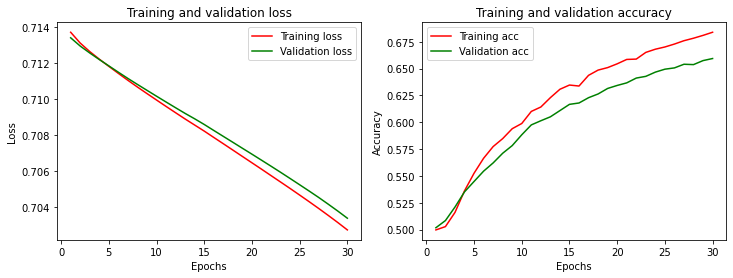

@@@ Training for adadelta for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.51]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.51, 0.51, 0.51, 0.51]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1s 4ms/step - loss: 0.7126 - a

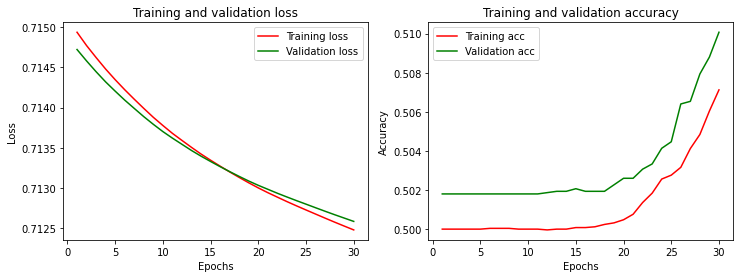

****************************************************************************************************
****************************************************************************************************
@@@ Training for adam for lr= 0.1

Train...

*********

training loss=
[1.08, 1.07, 0.86, 0.78, 0.83, 1.1, 1.55, 0.78, 0.75, 0.76, 0.71, 0.71, 0.92, 0.9, 0.79, 0.74, 0.72, 0.75, 0.83, 0.96, 1.25, 0.8, 0.76, 0.73, 0.72, 0.71, 0.7, 0.7, 0.7, 0.69]
validation loss=
[0.79, 0.97, 1.48, 0.8, 0.74, 2.34, 0.9, 0.78, 0.75, 0.73, 0.71, 1.36, 2.23, 1.27, 0.75, 0.76, 0.73, 0.76, 1.21, 0.89, 0.79, 0.76, 0.75, 0.73, 0.72, 0.71, 0.71, 0.71, 0.7, 0.7]
training accuracy=
[0.63, 0.61, 0.64, 0.69, 0.57, 0.52, 0.5, 0.5, 0.51, 0.51, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5]
validation accuracy=
[0.69, 0.66, 0.68, 0.51, 0.51, 0.5, 0.51, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.51, 0.51, 0.51

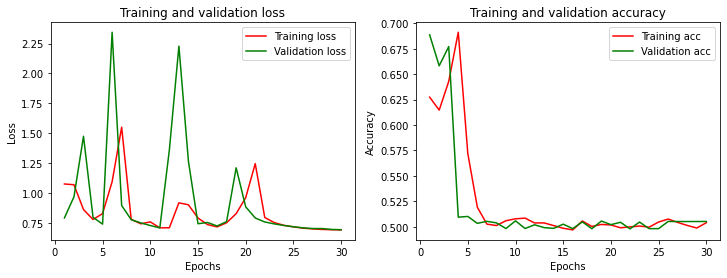

@@@ Training for adam for lr= 0.01

Train...

*********

training loss=
[0.4, 0.23, 0.14, 0.08, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]
validation loss=
[0.32, 0.38, 0.35, 0.44, 0.48, 0.52, 0.54, 0.53, 0.48, 0.45, 0.44, 0.44, 0.44, 0.44, 0.45, 0.45, 0.46, 0.47, 0.47, 0.48, 0.49, 0.5, 0.51, 0.51, 0.52, 0.53, 0.55, 0.56, 0.57, 0.59]
training accuracy=
[0.83, 0.92, 0.95, 0.98, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.87, 0.85, 0.88, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 5ms/step -

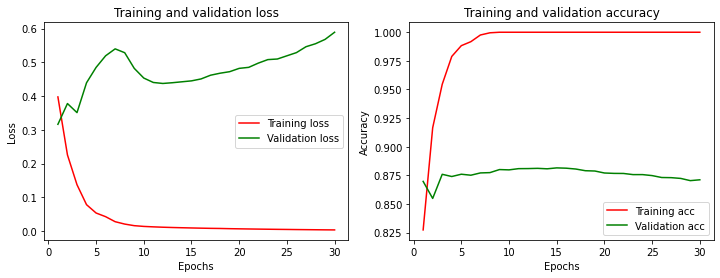

@@@ Training for adam for lr= 0.001

Train...

*********

training loss=
[0.54, 0.32, 0.25, 0.2, 0.16, 0.13, 0.1, 0.08, 0.07, 0.06, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01]
validation loss=
[0.38, 0.32, 0.32, 0.33, 0.35, 0.37, 0.4, 0.42, 0.45, 0.47, 0.49, 0.49, 0.5, 0.5, 0.51, 0.51, 0.51, 0.51, 0.52, 0.52, 0.53, 0.53, 0.54, 0.54, 0.55, 0.56, 0.56, 0.57, 0.57, 0.58]
training accuracy=
[0.75, 0.88, 0.91, 0.94, 0.96, 0.97, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.85, 0.87, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.85, 0.86]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 5ms/s

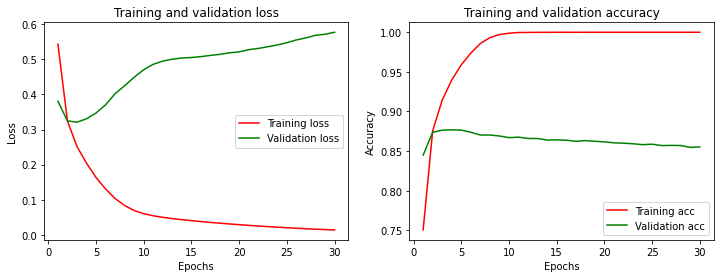

****************************************************************************************************
****************************************************************************************************


In [ ]:
# model having 2 different cnn layer with gfrid 3,4
batch_size = 128
epoch = 30
print("Training is being done for bathch size= {}, for  {} epochs".format(batch_size,epoch) )

l=["sgd","sgd_mntm","adagrad","rmsprop","adadelta","adam"]
for name_of_optim in l:
    for lr in [0.1,0.01,0.001]:
        print("@@@ Training for {} for lr= {}".format(name_of_optim,lr))
        training(name_of_optim,lr,epoch,batch_size)
    print("*"*100)
    print("*"*100)

Training is being done for bathch size= 512, for  30 epochs
@@@ Training for sgd for lr= 0.1

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.69, 0.68, 0.67, 0.66, 0.66, 0.65, 0.64, 0.64, 0.64, 0.63, 0.63, 0.63]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.68, 0.68, 0.67, 0.66, 0.65, 0.64, 0.64, 0.64, 0.63, 0.63, 0.63, 0.62]
training accuracy=
[0.51, 0.53, 0.54, 0.57, 0.59, 0.6, 0.6, 0.59, 0.63, 0.65, 0.64, 0.65, 0.67, 0.66, 0.67, 0.68, 0.69, 0.69, 0.69, 0.7, 0.68, 0.64, 0.63, 0.63, 0.63, 0.64, 0.66, 0.68, 0.68, 0.68]
validation accuracy=
[0.52, 0.5, 0.54, 0.58, 0.59, 0.62, 0.57, 0.53, 0.64, 0.65, 0.57, 0.67, 0.62, 0.68, 0.66, 0.69, 0.69, 0.68, 0.69, 0.69, 0.66, 0.65, 0.62, 0.62, 0.63, 0.65, 0.68, 0.67, 0.67, 0.68]

*********

____________________________________________________________________________________________________


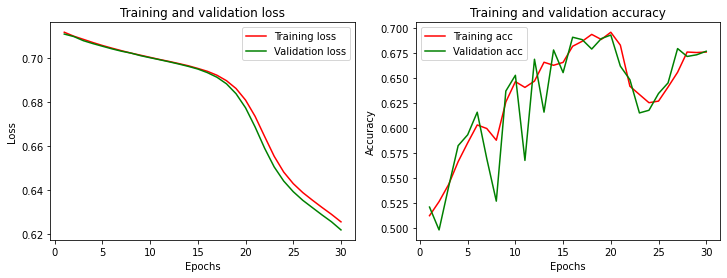

@@@ Training for sgd for lr= 0.01

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
training accuracy=
[0.5, 0.5, 0.51, 0.52, 0.52, 0.52, 0.53, 0.53, 0.54, 0.54, 0.54, 0.54, 0.55, 0.55, 0.55, 0.56, 0.56, 0.56, 0.57, 0.57, 0.57, 0.57, 0.58, 0.58, 0.58, 0.58, 0.58, 0.59, 0.59, 0.59]
validation accuracy=
[0.5, 0.51, 0.51, 0.51, 0.51, 0.52, 0.52, 0.53, 0.53, 0.53, 0.53, 0.54, 0.54, 0.54, 0.54, 0.54, 0.55, 0.55, 0.55, 0.55, 0.55, 0.56, 0.56, 0.56, 0.56, 0.56, 0.57, 0.57, 0.57, 0.57]

*********

____________________________________________________________________________________________________

Test...
313/313 [====================

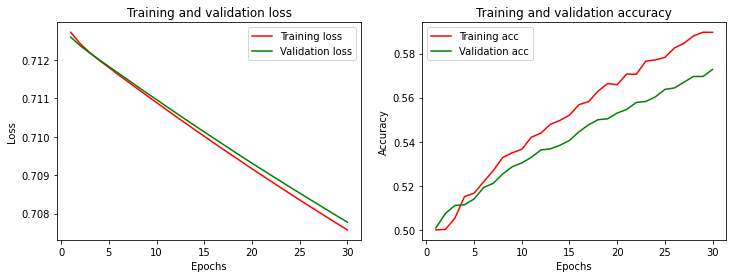

@@@ Training for sgd for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5]
validation accuracy=
[0.5, 0.49, 0.5, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.51]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1s 4ms/step - loss: 0.7122 - ac

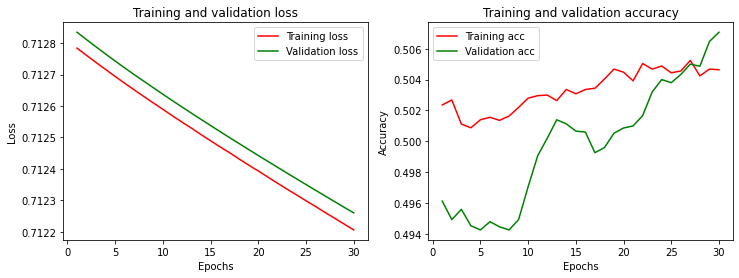

****************************************************************************************************
****************************************************************************************************
@@@ Training for sgd_mntm for lr= 0.1

Train...

*********

training loss=
[0.71, 0.7, 0.68, 0.65, 0.63, 0.6, 0.56, 0.51, 0.48, 0.45, 0.43, 0.41, 0.38, 0.36, 0.34, 0.33, 0.31, 0.3, 0.28, 0.27, 0.26, 0.24, 0.23, 0.22, 0.21, 0.2, 0.19, 0.18, 0.17, 0.16]
validation loss=
[0.7, 0.69, 0.66, 0.64, 0.62, 0.59, 0.54, 0.49, 0.47, 0.45, 0.44, 0.42, 0.4, 0.39, 0.38, 0.37, 0.37, 0.36, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.36, 0.36, 0.37, 0.38]
training accuracy=
[0.53, 0.55, 0.59, 0.63, 0.66, 0.68, 0.72, 0.76, 0.78, 0.8, 0.81, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.9, 0.91, 0.91, 0.92, 0.93, 0.93, 0.94, 0.94, 0.95, 0.95, 0.96]
validation accuracy=
[0.5, 0.63, 0.6, 0.65, 0.67, 0.69, 0.74, 0.77, 0.78, 0.8, 0.81, 0.82, 0.83, 0.83, 0.84, 0.85, 0.85, 0.85, 0.85, 0.86, 0.86, 0.86, 0.

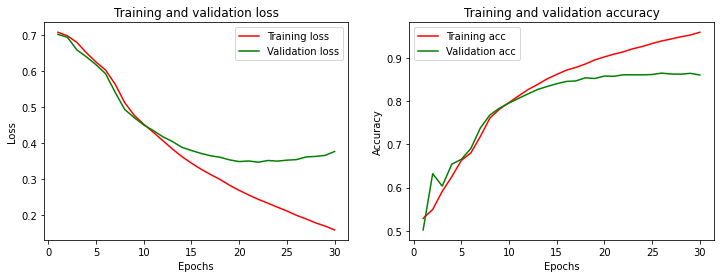

@@@ Training for sgd_mntm for lr= 0.01

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.68, 0.68, 0.68, 0.67, 0.67, 0.67, 0.66, 0.66]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.68, 0.68, 0.68, 0.67, 0.67, 0.67, 0.66, 0.66, 0.65]
training accuracy=
[0.5, 0.53, 0.52, 0.56, 0.56, 0.62, 0.63, 0.64, 0.65, 0.63, 0.65, 0.66, 0.64, 0.67, 0.68, 0.68, 0.68, 0.67, 0.64, 0.66, 0.65, 0.6, 0.59, 0.58, 0.58, 0.58, 0.58, 0.58, 0.59, 0.61]
validation accuracy=
[0.52, 0.53, 0.51, 0.54, 0.59, 0.61, 0.61, 0.63, 0.63, 0.66, 0.65, 0.67, 0.64, 0.67, 0.67, 0.66, 0.66, 0.65, 0.67, 0.65, 0.61, 0.6, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.6, 0.62]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1s

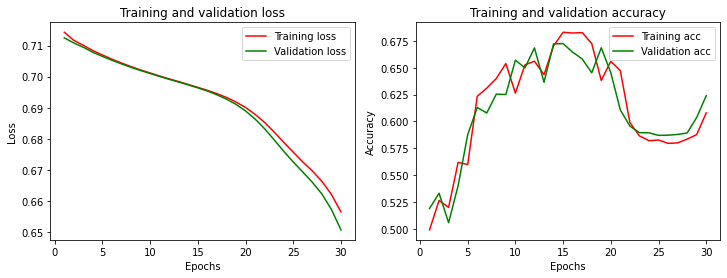

@@@ Training for sgd_mntm for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.51, 0.51, 0.52, 0.52, 0.52, 0.53, 0.53, 0.53, 0.53, 0.54, 0.54, 0.55, 0.55, 0.55, 0.56, 0.55, 0.56, 0.56, 0.57, 0.57, 0.57, 0.58, 0.58, 0.58, 0.58, 0.58]
validation accuracy=
[0.5, 0.5, 0.5, 0.51, 0.51, 0.52, 0.52, 0.52, 0.53, 0.53, 0.53, 0.53, 0.54, 0.54, 0.54, 0.54, 0.55, 0.55, 0.55, 0.55, 0.56, 0.56, 0.56, 0.56, 0.56, 0.57, 0.57, 0.57, 0.58, 0.58]

*********

____________________________________________________________________________________________________

Test...
313/313 [==================

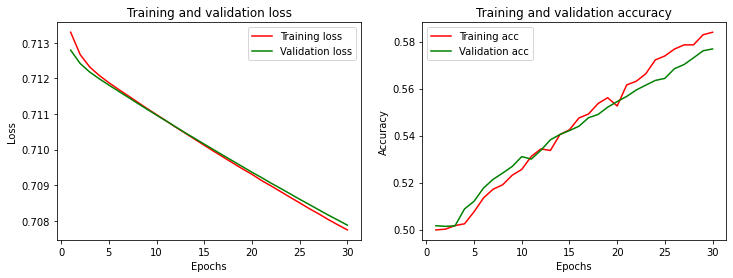

****************************************************************************************************
****************************************************************************************************
@@@ Training for adagrad for lr= 0.1

Train...

*********

training loss=
[0.71, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.68, 0.65, 0.64, 0.63, 0.62, 0.6, 0.58, 0.57, 0.55, 0.54, 0.52, 0.51, 0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.43, 0.42, 0.41, 0.4]
validation loss=
[0.71, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.67, 0.64, 0.63, 0.62, 0.61, 0.59, 0.58, 0.56, 0.55, 0.54, 0.52, 0.51, 0.49, 0.48, 0.47, 0.47, 0.46, 0.45, 0.44, 0.44, 0.43, 0.42, 0.42]
training accuracy=
[0.52, 0.55, 0.57, 0.6, 0.64, 0.66, 0.65, 0.66, 0.67, 0.69, 0.7, 0.71, 0.71, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.79, 0.8, 0.8, 0.81, 0.81, 0.82, 0.83, 0.83]
validation accuracy=
[0.58, 0.54, 0.66, 0.6, 0.68, 0.67, 0.67, 0.6, 0.69, 0.69, 0.69, 0.7, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.78, 0.79, 0.

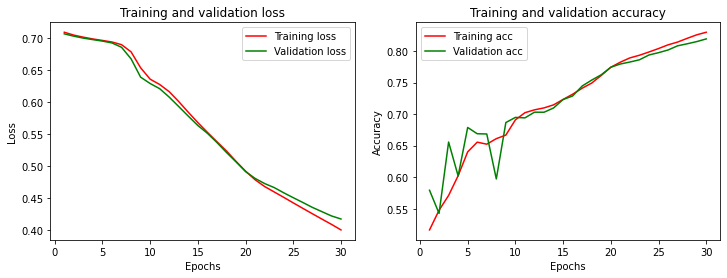

@@@ Training for adagrad for lr= 0.01

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
training accuracy=
[0.5, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.55, 0.56, 0.57, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.61, 0.62, 0.63, 0.62, 0.62, 0.64, 0.64, 0.64, 0.64, 0.65, 0.64, 0.65, 0.65]
validation accuracy=
[0.5, 0.5, 0.51, 0.52, 0.52, 0.53, 0.54, 0.55, 0.56, 0.56, 0.57, 0.56, 0.59, 0.59, 0.59, 0.61, 0.61, 0.61, 0.61, 0.62, 0.6, 0.62, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64, 0.64]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1s 4ms/step -

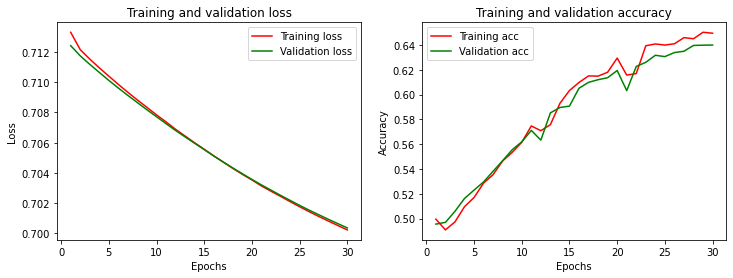

@@@ Training for adagrad for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.51, 0.51, 0.51, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.53, 0.53, 0.53, 0.53, 0.53]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.51, 0.51, 0.51, 0.51, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================

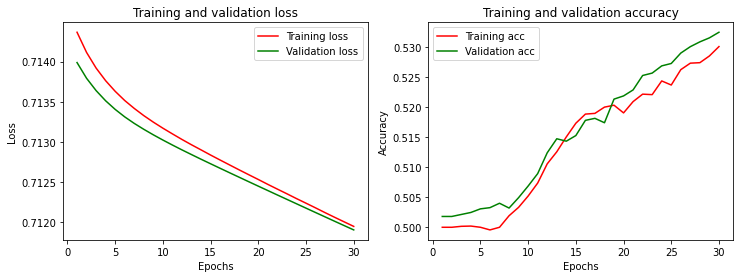

****************************************************************************************************
****************************************************************************************************
@@@ Training for rmsprop for lr= 0.1

Train...

*********

training loss=
[15.13, 1.17, 0.93, 0.84, 0.77, 0.8, 0.74, 0.71, 0.88, 0.74, 0.74, 0.76, 0.7, 0.75, 0.69, 0.74, 0.71, 0.73, 0.69, 0.87, 0.66, 0.69, 0.86, 0.69, 0.68, 0.65, 0.74, 0.74, 0.66, 0.61]
validation loss=
[1.35, 0.94, 0.72, 0.81, 0.75, 0.94, 1.03, 1.65, 1.33, 1.13, 1.63, 1.28, 1.32, 1.4, 1.36, 1.78, 1.46, 2.47, 2.03, 2.44, 4.22, 2.57, 2.38, 2.78, 3.86, 3.61, 3.9, 4.45, 5.28, 4.97]
training accuracy=
[0.6, 0.62, 0.65, 0.68, 0.69, 0.71, 0.73, 0.74, 0.76, 0.77, 0.78, 0.78, 0.79, 0.79, 0.8, 0.79, 0.81, 0.81, 0.81, 0.82, 0.83, 0.83, 0.82, 0.83, 0.83, 0.83, 0.83, 0.84, 0.84, 0.84]
validation accuracy=
[0.54, 0.59, 0.67, 0.58, 0.69, 0.72, 0.65, 0.74, 0.68, 0.7, 0.59, 0.75, 0.69, 0.71, 0.72, 0.74, 0.74, 0.7, 0.7, 0.73, 0.74, 0.72,

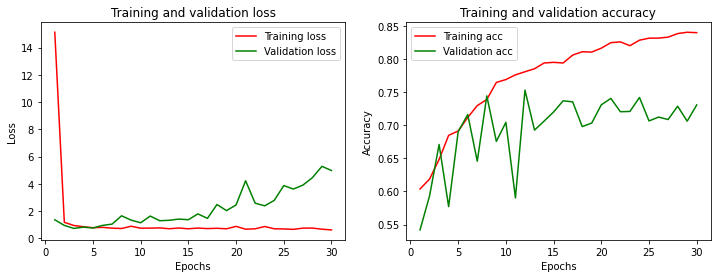

@@@ Training for rmsprop for lr= 0.01

Train...

*********

training loss=
[0.51, 0.32, 0.26, 0.2, 0.14, 0.1, 0.09, 0.06, 0.05, 0.05, 0.05, 0.02, 0.04, 0.04, 0.04, 0.01, 0.03, 0.01, 0.03, 0.03, 0.01, 0.03, 0.01, 0.03, 0.02, 0.01, 0.02, 0.02, 0.01, 0.02]
validation loss=
[0.39, 0.34, 0.34, 0.36, 0.46, 0.39, 0.44, 0.48, 0.5, 0.53, 0.56, 0.81, 0.55, 0.55, 0.62, 0.55, 0.55, 0.53, 0.55, 0.57, 0.55, 0.57, 0.64, 0.58, 0.59, 0.56, 0.6, 0.61, 0.59, 0.61]
training accuracy=
[0.76, 0.87, 0.9, 0.93, 0.95, 0.97, 0.97, 0.99, 0.99, 0.99, 0.99, 1.0, 0.99, 0.99, 0.99, 1.0, 0.99, 1.0, 0.99, 0.99, 1.0, 0.99, 1.0, 0.99, 0.99, 1.0, 1.0, 0.99, 1.0, 1.0]
validation accuracy=
[0.84, 0.86, 0.87, 0.86, 0.84, 0.87, 0.87, 0.87, 0.86, 0.87, 0.87, 0.83, 0.87, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.85, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86]

*********

____________________________________________________________________________________________________

Test...
313/313 [===========================

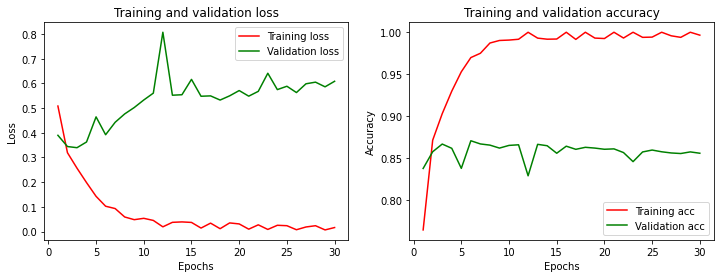

@@@ Training for rmsprop for lr= 0.001

Train...

*********

training loss=
[0.63, 0.43, 0.34, 0.3, 0.27, 0.24, 0.22, 0.2, 0.19, 0.17, 0.16, 0.15, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.08, 0.07, 0.07, 0.06, 0.06, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04]
validation loss=
[0.51, 0.38, 0.35, 0.33, 0.33, 0.33, 0.33, 0.33, 0.34, 0.35, 0.36, 0.37, 0.37, 0.38, 0.4, 0.41, 0.42, 0.43, 0.45, 0.46, 0.48, 0.49, 0.5, 0.51, 0.51, 0.52, 0.53, 0.53, 0.53, 0.54]
training accuracy=
[0.72, 0.83, 0.87, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.96, 0.97, 0.97, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.8, 0.85, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================

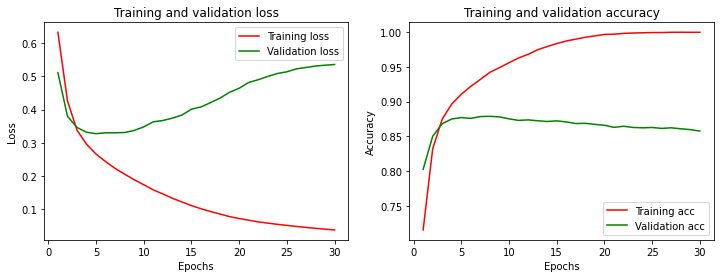

****************************************************************************************************
****************************************************************************************************
@@@ Training for adadelta for lr= 0.1

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.68, 0.67, 0.67, 0.66, 0.65, 0.65, 0.64, 0.64, 0.64, 0.63]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.68, 0.68, 0.67, 0.66, 0.66, 0.65, 0.65, 0.64, 0.64, 0.63, 0.63]
training accuracy=
[0.51, 0.54, 0.56, 0.59, 0.61, 0.63, 0.65, 0.64, 0.64, 0.67, 0.67, 0.68, 0.69, 0.7, 0.7, 0.71, 0.71, 0.71, 0.71, 0.7, 0.69, 0.68, 0.66, 0.66, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65]
validation accuracy=
[0.52, 0.55, 0.57, 0.58, 0.61, 0.62, 0.64, 0.65, 0.64, 0.66, 0.66, 0.67, 0.67, 0.68, 0.69, 0.7, 0.69, 0.69, 0.69, 0.68, 0.67, 0.66, 0.65, 0.65,

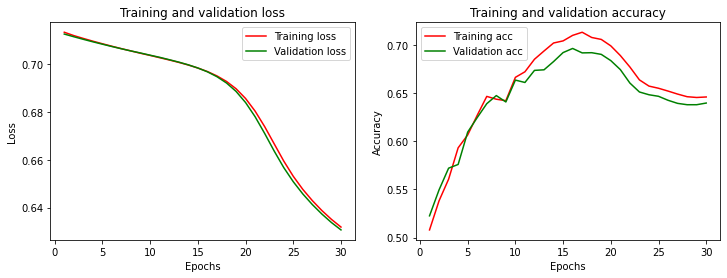

@@@ Training for adadelta for lr= 0.01

Train...

*********

training loss=
[0.72, 0.72, 0.72, 0.72, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
validation loss=
[0.72, 0.72, 0.72, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.52, 0.52, 0.53, 0.54, 0.54, 0.55, 0.56, 0.57, 0.57, 0.58, 0.58, 0.58, 0.58, 0.58, 0.59]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.51, 0.51, 0.52, 0.52, 0.53, 0.53, 0.54, 0.54, 0.55, 0.55, 0.56, 0.56, 0.57, 0.57, 0.57, 0.58, 0.58]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1s 5

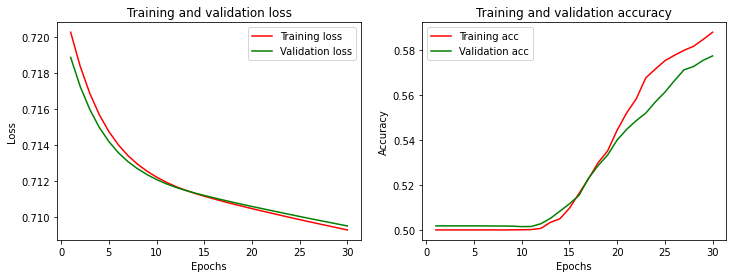

@@@ Training for adadelta for lr= 0.001

Train...

*********

training loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
validation loss=
[0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
training accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
validation accuracy=
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1s 5ms/step - loss: 0.7120 - accuracy

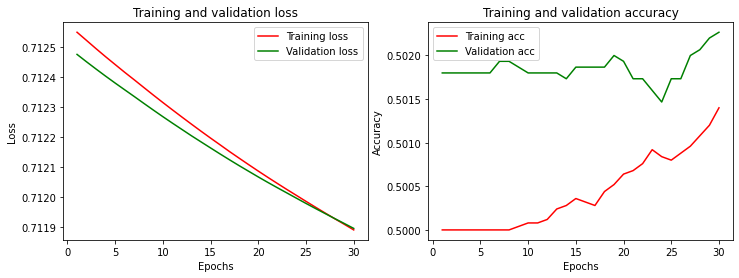

****************************************************************************************************
****************************************************************************************************
@@@ Training for adam for lr= 0.1

Train...

*********

training loss=
[1.34, 0.45, 0.35, 0.3, 0.27, 0.23, 0.26, 0.2, 0.18, 0.17, 0.25, 0.22, 0.21, 0.16, 0.12, 0.12, 0.11, 0.16, 0.16, 0.16, 0.32, 0.47, 1.18, 0.85, 0.79, 0.78, 0.87, 0.75, 0.7, 0.71]
validation loss=
[0.52, 0.42, 0.43, 0.5, 0.44, 0.47, 0.53, 0.53, 0.59, 0.66, 0.58, 0.55, 0.82, 0.75, 0.75, 0.9, 1.13, 1.21, 0.89, 1.48, 1.17, 1.03, 1.03, 1.27, 0.78, 0.97, 0.85, 0.76, 0.83, 0.73]
training accuracy=
[0.64, 0.82, 0.86, 0.88, 0.9, 0.91, 0.91, 0.93, 0.94, 0.94, 0.91, 0.93, 0.94, 0.95, 0.96, 0.96, 0.97, 0.95, 0.95, 0.96, 0.95, 0.9, 0.72, 0.67, 0.52, 0.51, 0.53, 0.55, 0.61, 0.58]
validation accuracy=
[0.78, 0.83, 0.83, 0.81, 0.82, 0.82, 0.82, 0.83, 0.83, 0.82, 0.83, 0.81, 0.8, 0.82, 0.82, 0.82, 0.81, 0.81, 0.81, 0.81, 0.82, 0.67, 0.

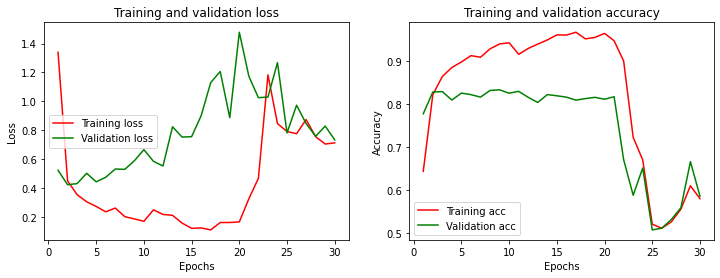

@@@ Training for adam for lr= 0.01

Train...

*********

training loss=
[0.45, 0.24, 0.15, 0.09, 0.05, 0.04, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
validation loss=
[0.33, 0.32, 0.36, 0.38, 0.42, 0.44, 0.45, 0.44, 0.44, 0.43, 0.43, 0.44, 0.44, 0.45, 0.45, 0.46, 0.46, 0.47, 0.47, 0.47, 0.48, 0.48, 0.49, 0.49, 0.5, 0.5, 0.51, 0.51, 0.52, 0.52]
training accuracy=
[0.79, 0.91, 0.96, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 2s 5ms/ste

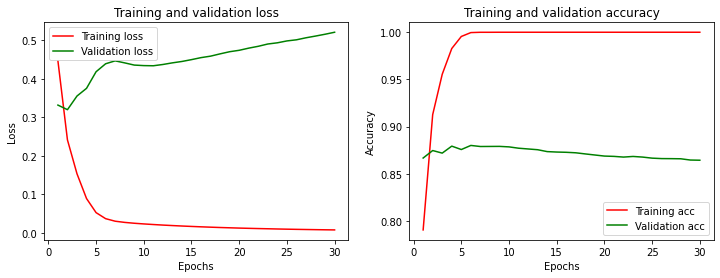

@@@ Training for adam for lr= 0.001

Train...

*********

training loss=
[0.68, 0.48, 0.34, 0.28, 0.25, 0.22, 0.19, 0.17, 0.15, 0.13, 0.12, 0.1, 0.09, 0.08, 0.07, 0.07, 0.06, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04]
validation loss=
[0.61, 0.39, 0.34, 0.33, 0.33, 0.33, 0.34, 0.35, 0.36, 0.38, 0.4, 0.42, 0.43, 0.45, 0.47, 0.48, 0.5, 0.51, 0.52, 0.52, 0.53, 0.53, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54]
training accuracy=
[0.69, 0.81, 0.87, 0.9, 0.92, 0.93, 0.95, 0.96, 0.97, 0.98, 0.98, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
validation accuracy=
[0.78, 0.84, 0.87, 0.87, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.85, 0.86, 0.86]

*********

____________________________________________________________________________________________________

Test...
313/313 [==============================] - 1s

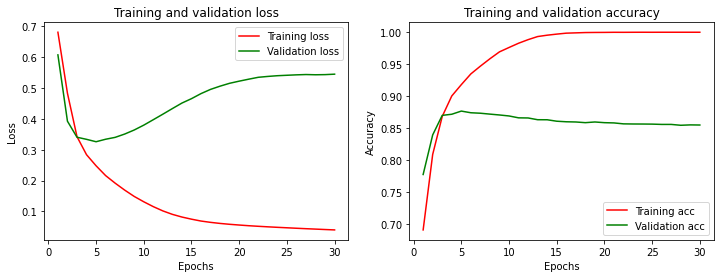

****************************************************************************************************
****************************************************************************************************


In [ ]:
# model having 2 different cnn layer with gfrid 3,4
batch_size = 512
epoch = 30
print("Training is being done for bathch size= {}, for  {} epochs".format(batch_size,epoch) )

l=["sgd","sgd_mntm","adagrad","rmsprop","adadelta","adam"]
for name_of_optim in l:
    for lr in [0.1,0.01,0.001]:
        print("@@@ Training for {} for lr= {}".format(name_of_optim,lr))
        training(name_of_optim,lr,epoch,batch_size)
    print("*"*100)
    print("*"*100)